<a href="https://colab.research.google.com/github/yeonyoo/Final-Team2/blob/main/Final_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/combined_dataset.csv')

In [2]:
#ÌïúÍ∏Ä Í∏ÄÏî® Ìè∞Ìä∏ ÏÑ§Ïπò
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'

# ÌëúÏóêÏÑú ('-') ÎßàÏù¥ÎÑàÏä§ ÌëúÏãú
plt.rcParams['axes.unicode_minus'] = False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11446 entries, 0 to 11445
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            11446 non-null  int64  
 1   listing_url                                   11446 non-null  object 
 2   scrape_id                                     11446 non-null  int64  
 3   last_scraped                                  11446 non-null  object 
 4   source                                        11446 non-null  object 
 5   name                                          11446 non-null  object 
 6   description                                   9276 non-null   object 
 7   neighborhood_overview                         5663 non-null   object 
 8   picture_url                                   11446 non-null  object 
 9   host_id                                       11446 non-null 

In [4]:
df.shape

(11446, 75)

In [5]:
df['host_response_rate'].describe()

count     10000
unique       62
top        100%
freq       7899
Name: host_response_rate, dtype: object

In [6]:
df['host_acceptance_rate'].describe()

count     10641
unique       95
top        100%
freq       5668
Name: host_acceptance_rate, dtype: object

In [7]:
df['host_response_time'].describe()

count              10000
unique                 4
top       within an hour
freq                8461
Name: host_response_time, dtype: object

#Ï†ÑÏ≤òÎ¶¨

In [8]:
#Ï†ÑÏ≤òÎ¶¨
df_clean = df.copy()


#Î¶¨Î∑∞ Í∞úÏàò Î≥Ñ Í∑∏Î£π ÏÑ∏Î∂ÑÌôî
bins = [-1, 0, 4, 100, 200, 300, 400, 500, 600, float("inf")]
labels = ["zero", "under_5", "review_100", "review_200", "review_300",
          "review_400", "review_500", "review_600", "review_700+"]
df_clean["host_review_grade"] = pd.cut(df_clean["number_of_reviews"],
                                       bins=bins, labels=labels)



# host_response_rate host_acceptance_rate  Ïà´Ïûê Î≥ÄÌôò
df_clean['host_response_rate'] = df_clean['host_response_rate'].replace('%','', regex=True).astype(float)
df_clean['host_acceptance_rate'] = df_clean['host_acceptance_rate'].replace('%','', regex=True).astype(float)



#Ìò∏Ïä§ÌåÖ Í∏∞Í∞Ñ hosting_days, hosting_yearsÍ≥ÑÏÇ∞: last_scraped - host_since
#objecct -> datetime ÎÇ†Ïßú ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò
df_clean['last_scraped'] = pd.to_datetime(df_clean['last_scraped'])
df_clean['host_since'] = pd.to_datetime(df_clean['host_since'])
df_clean['hosting_days'] = (df_clean['last_scraped'] - df_clean['host_since']).dt.days
df_clean['hosting_years'] = df_clean['hosting_days'] / 365.25



#Ìò∏Ïä§ÌåÖ ÏãúÏûëÌïòÍ≥† Ï≤´ Î¶¨Î∑∞ Î∞õÍ∏∞ÍπåÏßÄÏùò Í∏∞Í∞Ñ til_first_review_days, til_first_review_years : host_since  - first_review
df_clean['first_review'] = pd.to_datetime(df_clean['first_review'])
df_clean['last_review'] = pd.to_datetime(df_clean['last_review'])
df_clean['til_first_review_days'] = (df_clean['first_review']-df_clean['host_since']).dt.days
df_clean['til_first_review_years'] = df_clean['til_first_review_days'] / 365.25



#til_first_review_days Í∞Ä ÏùåÏàòÏù∏ Ï¥ù 33Í∞úÏóê ÎåÄÌïòÏó¨ Í∞Å Í∑∏Î£πÎ≥Ñ 'Ï§ëÏïôÍ∞í'ÏúºÎ°ú ÎåÄÏπò
# 1) Í∑∏Î£πÎ≥Ñ Ï§ëÏïôÍ∞í(ÏùåÏàò Ï†úÏô∏ÌïòÍ≥† Í≥ÑÏÇ∞)
group_medians = (
    df_clean[df_clean["til_first_review_days"] >= 0]
    .groupby("host_review_grade")["til_first_review_days"]
    .median())
# 2) ÏùåÏàòÍ∞íÏùÑ Í∑∏Î£πÎ≥Ñ Ï§ëÏïôÍ∞íÏúºÎ°ú ÎåÄÏπò
def replace_with_group_median(row):
    if row["til_first_review_days"] < 0:
        return group_medians[row["host_review_grade"]]
    else:
        return row["til_first_review_days"]
df_clean["til_first_review_days"] = df_clean.apply(replace_with_group_median, axis=1)
# 3) til_first_review_yearsÎèÑ Îã§Ïãú ÏóÖÎç∞Ïù¥Ìä∏
df_clean["til_first_review_years"] = df_clean["til_first_review_days"] / 365.25



#host_response_time Í≤∞Ï∏°Ïπò Unknown ÏúºÎ°ú Î≥ÄÍ≤Ω
df_clean['host_response_time'] = df_clean['host_response_time'].fillna('Unknown')



# ÏùëÎãµÏãúÍ∞Ñ Ï†êÏàòÌôî (Îπ†Î•ºÏàòÎ°ù ÎÜíÏùÄ Ï†êÏàò)
resp_time_score_map = {
    "within an hour": 4,
    "within a few hours": 3,
    "within a day": 2,
    "a few days or more": 1,
    "Unknown": 0}
df_clean["host_response_time_score"] = df_clean["host_response_time"].map(resp_time_score_map)

/tmp/ipython-input-2634914392.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("host_review_grade")["til_first_review_days"]


In [9]:
df_clean.shape

(11446, 81)

In [10]:
df['host_response_rate'].describe()

count     10000
unique       62
top        100%
freq       7899
Name: host_response_rate, dtype: object

In [11]:
df['host_acceptance_rate'].describe()

count     10641
unique       95
top        100%
freq       5668
Name: host_acceptance_rate, dtype: object

In [12]:
df['host_response_time'].describe()

count              10000
unique                 4
top       within an hour
freq                8461
Name: host_response_time, dtype: object

#ÏãúÍ∞ÅÌôî
(1) ÏùëÎãµÎ•† vs Î¶¨Î∑∞Ïàò  
(2) ÏùëÎãµÏãúÍ∞Ñ(Î¨∏ÏûêÏó¥) vs Î¶¨Î∑∞Ïàò  ‚Äî Í≤∞Ï∏°ÏπòÎäî 'Unknown'ÏúºÎ°ú ÌëúÏãú  
(3) ÏàòÎùΩÎ•† vs Î¶¨Î∑∞Ïàò

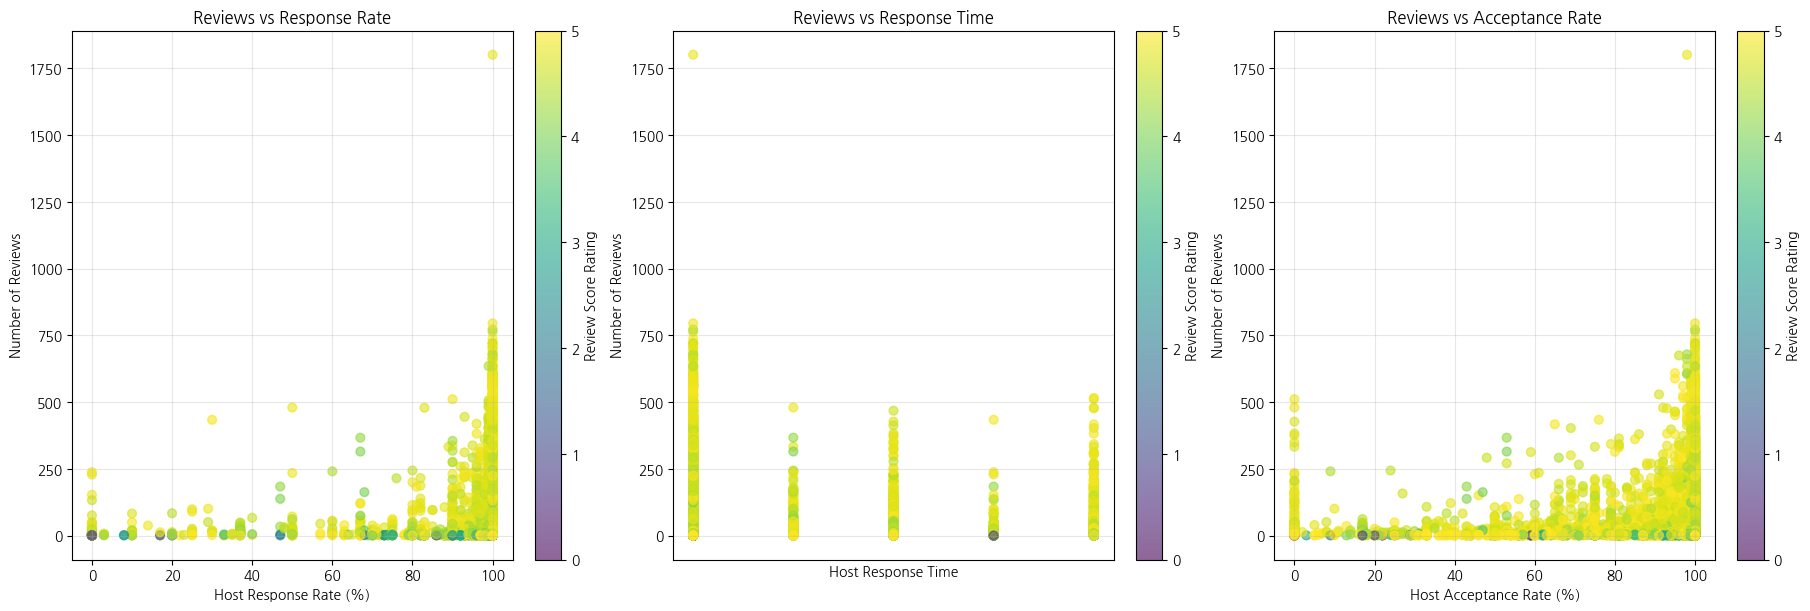

In [14]:
# === ÏÇ∞Ï†êÎèÑ 3Ï¢Ö ===

import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# Í≥µÌÜµ ÏÑ§Ï†ï - ÏÇ∞Ï†êÎèÑ ÏÉâÍπîÏùÑ Î¶¨Î∑∞ ÌèâÏ†ê(review_scores_rating) Í∞íÏúºÎ°ú ÏûÖÌûàÍ≥†, ÏÉâÏÉÅÎ∞î(colorbar) Î†àÏù¥Î∏îÎèÑ ÏûêÎèôÏúºÎ°ú Ï∂îÍ∞Ä
cvals = df_clean['review_scores_rating'] if 'review_scores_rating' in df_clean.columns else None
cbar_label = 'Review Score Rating' if cvals is not None else None

# (1) ÏùëÎãµÎ•† vs Î¶¨Î∑∞Ïàò
sc0 = axes[0].scatter(
    df_clean['host_response_rate'],
    df_clean['number_of_reviews'],
    c=cvals, cmap='viridis', alpha=0.6, s=40
)
if cvals is not None:
    fig.colorbar(sc0, ax=axes[0], label=cbar_label)
axes[0].set_xlabel('Host Response Rate (%)')
axes[0].set_ylabel('Number of Reviews')
axes[0].set_title('Reviews vs Response Rate')
axes[0].grid(True, alpha=0.3)

# (2) ÏùëÎãµÏãúÍ∞Ñ(Î¨∏ÏûêÏó¥) vs Î¶¨Î∑∞Ïàò  ‚Äî Í≤∞Ï∏°ÏπòÎäî 'Unknown'ÏúºÎ°ú ÌëúÏãú
sc1 = axes[1].scatter(
     df_clean['host_response_time'],
    df_clean['number_of_reviews'],
    c=cvals, cmap='viridis', alpha=0.6, s=40
)
if cvals is not None:
    fig.colorbar(sc1, ax=axes[1], label=cbar_label)
# Ïπ¥ÌÖåÍ≥†Î¶¨ ÏàúÏÑú ÏßÄÏ†ï(Îç∞Ïù¥ÌÑ∞Ïóê ÏûàÎäî Í≤ÉÎßå ÌëúÏãú)
ordered = ['within an hour','within a few hours','within a day','a few days or more','Unknown']
present = [lab for lab in ordered if lab in set(df_clean)]
axes[1].set_xticks(range(len(present)))
axes[1].set_xticklabels(present, rotation=15)
axes[1].set_xlabel('Host Response Time')
axes[1].set_ylabel('Number of Reviews')
axes[1].set_title('Reviews vs Response Time')
axes[1].grid(True, alpha=0.3)

# (3) ÏàòÎùΩÎ•† vs Î¶¨Î∑∞Ïàò
sc2 = axes[2].scatter(
    df_clean['host_acceptance_rate'],
    df_clean['number_of_reviews'],
    c=cvals, cmap='viridis', alpha=0.6, s=40
)
if cvals is not None:
    fig.colorbar(sc2, ax=axes[2], label=cbar_label)
axes[2].set_xlabel('Host Acceptance Rate (%)')
axes[2].set_ylabel('Number of Reviews')
axes[2].set_title('Reviews vs Acceptance Rate')
axes[2].grid(True, alpha=0.3)

plt.show()



In [15]:
df_clean['number_of_reviews'].describe()

count    11446.000000
mean        59.958850
std         99.617144
min          0.000000
25%          3.000000
50%         18.000000
75%         70.000000
max       1801.000000
Name: number_of_reviews, dtype: float64

###Ï†ÑÏ≤òÎ¶¨) Í∑πÎã®Ïπò ÎåÄÏπò Ï°∞Ïñ∏ Íµ¨ÌïòÍ∏∞

In [16]:
# Í∑πÎã®Ïπò ÎåÄÏπò - number_of_reviewsÍ∞Ä 1801Ïù∏ Í∑πÎã®ÏπòÎ•º Í∑∏ Îã§Ïùå ÏûëÏùÄ ÏàòÎ°ú ÎåÄÏπò
# ÏµúÎåÄÍ∞íÍ≥º Îëê Î≤àÏß∏ ÏµúÎåÄÍ∞í Ï∞æÍ∏∞
review_max = df_clean['number_of_reviews'].max()
second_max = df_clean.loc[df_clean['number_of_reviews'] < review_max, 'number_of_reviews'].max()

# ÏµúÎåÄÍ∞íÏùÑ Îëê Î≤àÏß∏ ÏµúÎåÄÍ∞íÏúºÎ°ú ÎåÄÏ≤¥
df_clean.loc[df_clean['number_of_reviews'] == review_max, 'number_of_reviews'] = second_max

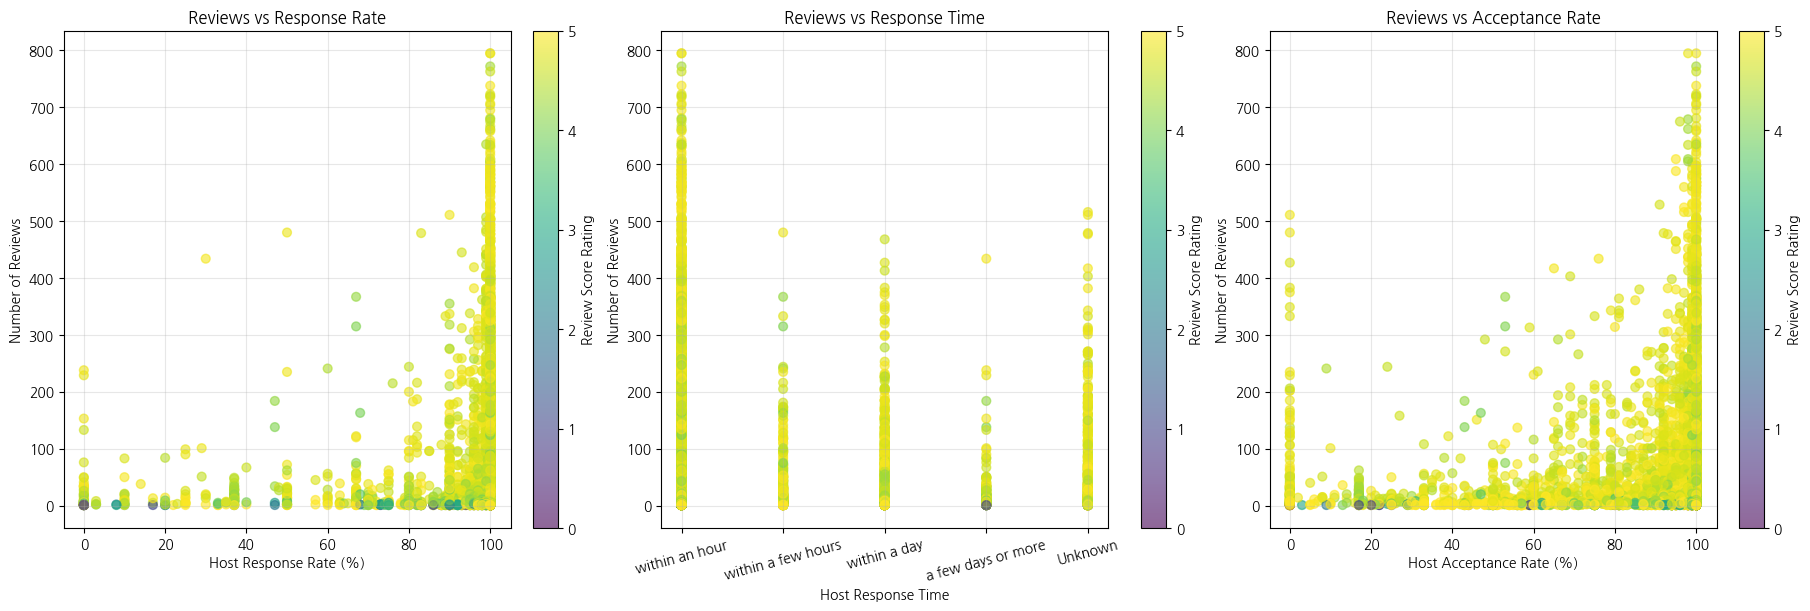

In [17]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# Í≥µÌÜµ ÏÑ§Ï†ï - ÏÇ∞Ï†êÎèÑ ÏÉâÍπîÏùÑ Î¶¨Î∑∞ ÌèâÏ†ê(review_scores_rating) Í∞íÏúºÎ°ú ÏûÖÌûàÍ≥†, ÏÉâÏÉÅÎ∞î(colorbar) Î†àÏù¥Î∏îÎèÑ ÏûêÎèôÏúºÎ°ú Ï∂îÍ∞Ä
cvals = df_clean['review_scores_rating'] if 'review_scores_rating' in df_clean.columns else None
cbar_label = 'Review Score Rating' if cvals is not None else None

# (1) ÏùëÎãµÎ•† vs Î¶¨Î∑∞Ïàò
sc0 = axes[0].scatter(
    df_clean['host_response_rate'],
    df_clean['number_of_reviews'],
    c=cvals, cmap='viridis', alpha=0.6, s=40
)
if cvals is not None:
    fig.colorbar(sc0, ax=axes[0], label=cbar_label)
axes[0].set_xlabel('Host Response Rate (%)')
axes[0].set_ylabel('Number of Reviews')
axes[0].set_title('Reviews vs Response Rate')
axes[0].grid(True, alpha=0.3)

# (2) ÏùëÎãµÏãúÍ∞Ñ(Î¨∏ÏûêÏó¥) vs Î¶¨Î∑∞Ïàò
sc1 = axes[1].scatter(
     df_clean['host_response_time'],
    df_clean['number_of_reviews'],
    c=cvals, cmap='viridis', alpha=0.6, s=40
)
if cvals is not None:
    fig.colorbar(sc1, ax=axes[1], label=cbar_label)
# Ïπ¥ÌÖåÍ≥†Î¶¨ ÏàúÏÑú ÏßÄÏ†ï(Îç∞Ïù¥ÌÑ∞Ïóê ÏûàÎäî Í≤ÉÎßå ÌëúÏãú)
ordered = ['within an hour','within a few hours','within a day','a few days or more','Unknown']
present = [lab for lab in ordered if lab in set(df_clean['host_response_time'])]
axes[1].set_xticks(range(len(present)))
axes[1].set_xticklabels(present, rotation=15)
axes[1].set_xlabel('Host Response Time')
axes[1].set_ylabel('Number of Reviews')
axes[1].set_title('Reviews vs Response Time')
axes[1].grid(True, alpha=0.3)

# (3) ÏàòÎùΩÎ•† vs Î¶¨Î∑∞Ïàò
sc2 = axes[2].scatter(
    df_clean['host_acceptance_rate'],
    df_clean['number_of_reviews'],
    c=cvals, cmap='viridis', alpha=0.6, s=40
)
if cvals is not None:
    fig.colorbar(sc2, ax=axes[2], label=cbar_label)
axes[2].set_xlabel('Host Acceptance Rate (%)')
axes[2].set_ylabel('Number of Reviews')
axes[2].set_title('Reviews vs Acceptance Rate')
axes[2].grid(True, alpha=0.3)

plt.show()

###Ï∞®Ìä∏ Î∂ÑÏÑù
**Reviews vs Response Rate**
ÏùëÎãµÎ•†Ïù¥ ÎÜíÏùÑÏàòÎ°ù(ÌäπÌûà 100% Í∑ºÏ≤ò) Î¶¨Î∑∞ ÏàòÍ∞Ä ÎßéÏùÄ Ìò∏Ïä§Ìä∏Í∞Ä ÏßëÏ§ëÎêòÏñ¥ ÏûàÏùå.

**Reviews vs Response Time**  
ÏùëÎãµÏãúÍ∞ÑÏù¥ Îπ†Î•∏ Í∑∏Î£π(within an hour, within a few hours) ÏóêÏÑú Î¶¨Î∑∞ ÏàòÍ∞Ä ÎßéÍ≥† ÏùëÎãµÏù¥ ÎäêÎ¶∞ Í∑∏Î£π(a few days or more)ÏùÄ Í±∞Ïùò Î¶¨Î∑∞ ÏàòÍ∞Ä Ï†ÅÏùå.
Îπ†Î•∏ ÏùëÎãµÏù¥ Îçî ÎßéÏùÄ Î¶¨Î∑∞ ÌôïÎ≥¥ÏôÄ Ïó∞Í≤∞ÎêòÎäî Í≤ΩÌñ•ÏùÑ ÏãúÍ∞ÅÏ†ÅÏúºÎ°ú ÌôïÏù∏ Í∞ÄÎä•.

**Reviews vs Acceptance Rate**
ÏàòÎùΩÎ•†Ïù¥ ÎÜíÏùÑ ÏàòÎ°ù Î¶¨Î∑∞ ÏàòÍ∞Ä Ï¶ùÍ∞ÄÌïòÎäî Ìå®ÌÑ¥ÏùÑ Î≥¥ÏûÑ. Îã§Îßå Host Acceptance RateÍ∞Ä 0Ïù∏Îç∞ Î¶¨Î∑∞ ÏàòÍ∞Ä ÏûàÎäî Í∞íÎì§Ïóê ÎåÄÌï¥ÏÑúÎäî Ï≤òÎ¶¨Í∞Ä ÌïÑÏöîÌï¥Î≥¥ÏûÑ

#Í≤ÄÏ¶ù Ï†Ñ Í∞Å ÌïÑÎìúÎ≥Ñ Í≤∞Ï∏°Í∞í ÌôïÏù∏
(host_response_timeÏùÄ Ïù¥ÎØ∏ ÏïûÏóêÏÑú Ï≤òÎ¶¨ Ìï®_Î≤îÏ£ºÌòï UnknownÏúºÎ°ú)

In [18]:
df_clean[['host_response_rate','host_acceptance_rate']].isna().sum()

host_response_rate      1446
host_acceptance_rate     805
dtype: int64

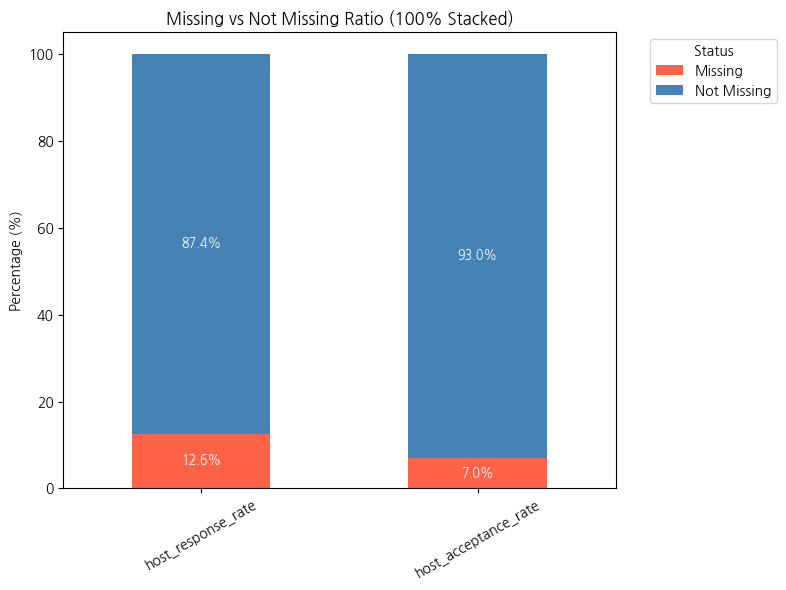

In [19]:
import matplotlib.pyplot as plt

# ÌôïÏù∏Ìï† Ïª¨ÎüºÎì§
cols = ['host_response_rate', 'host_acceptance_rate']

# Í≤∞Ï∏°/ÎπÑÍ≤∞Ï∏° Í∞úÏàò Í≥ÑÏÇ∞
missing = df_clean[cols].isnull().sum()
not_missing = df_clean[cols].notnull().sum()

df_missing = pd.DataFrame({
    'Missing': missing,
    'Not Missing': not_missing
}, index=cols)

# ÎπÑÏú® Î≥ÄÌôò (%)
df_ratio = df_missing.div(df_missing.sum(axis=1), axis=0) * 100

# ÌîåÎ°Ø
ax = df_ratio.plot(
    kind='bar',
    stacked=True,
    figsize=(8,6),
    color=['tomato','steelblue']
)

plt.title("Missing vs Not Missing Ratio (100% Stacked)")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=30)
plt.legend(title="Status", bbox_to_anchor=(1.05,1), loc='upper left')

# --- ÏàòÏπò ÎùºÎ≤® ÌëúÏãú ---
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:  # ÎπÑÏú®Ïù¥ 0Ïù¥ ÏïÑÎãê ÎïåÎßå ÌëúÏãú
        ax.text(x + width/2, y + height/2,
                f"{height:.1f}%",
                ha='center', va='center', fontsize=9, color='white', fontweight='bold')

plt.tight_layout()
plt.show()


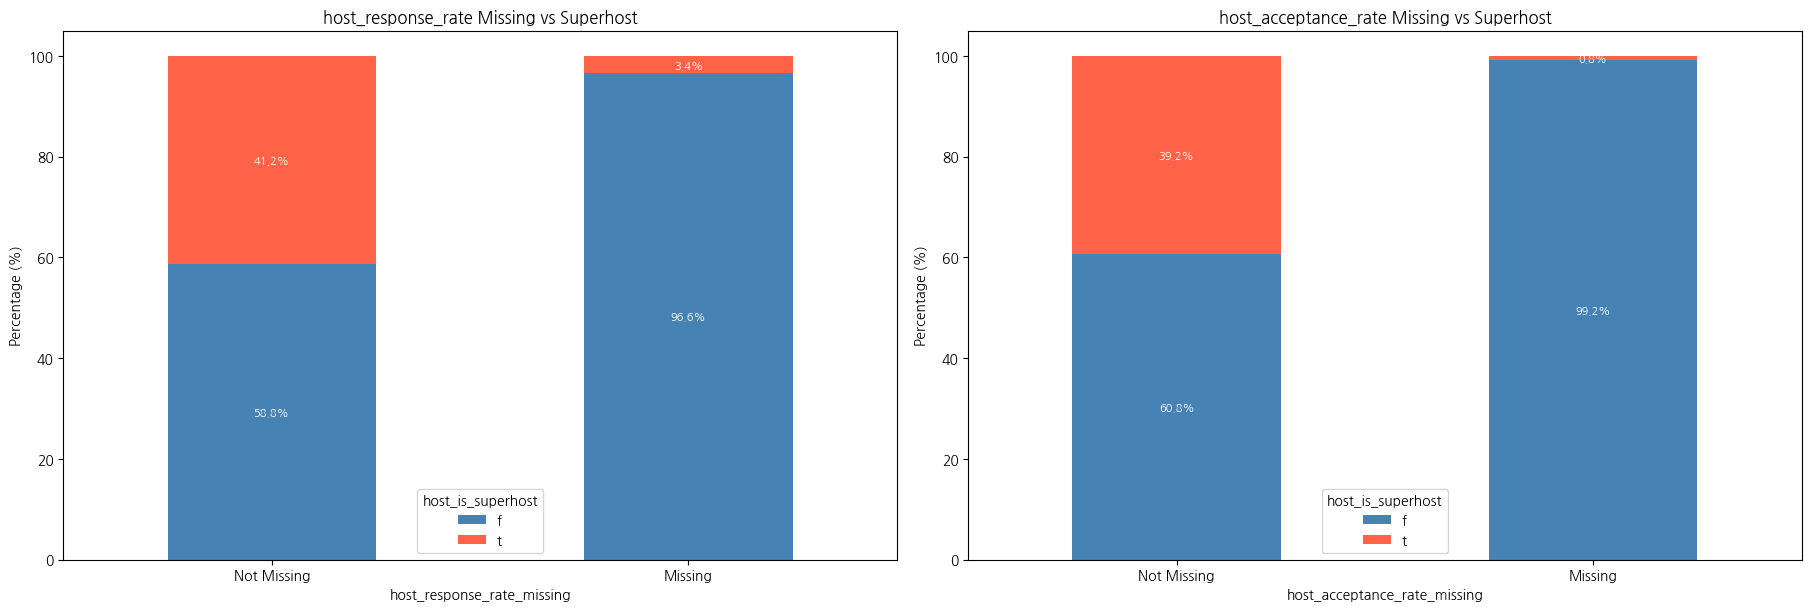

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

cols = ['host_response_rate', 'host_acceptance_rate']

fig, axes = plt.subplots(1, 2, figsize=(18,6), constrained_layout=True)

for i, col in enumerate(cols):
    # Í≤∞Ï∏° Ïó¨Î∂Ä ÌîåÎûòÍ∑∏
    df_clean[col + '_missing'] = df_clean[col].isna()

    # ÍµêÏ∞®Ìëú: Í≤∞Ï∏° Ïó¨Î∂Ä vs ÏäàÌçºÌò∏Ïä§Ìä∏
    cross = pd.crosstab(df_clean[col + '_missing'], df_clean['host_is_superhost'], normalize='index') * 100

    # ÌîåÎ°Ø
    cross.plot(kind='bar', stacked=True, ax=axes[i], color=['steelblue','tomato'])
    axes[i].set_title(f"{col} Missing vs Superhost")
    axes[i].set_ylabel("Percentage (%)")
    axes[i].set_xticklabels(['Not Missing','Missing'], rotation=0)

    # ÏàòÏπò ÎùºÎ≤® ÌëúÏãú
    for p in axes[i].patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        if height > 0:
            axes[i].text(x + width/2, y + height/2,
                         f"{height:.1f}%",
                         ha='center', va='center', fontsize=8, color='white', fontweight='bold')

plt.show()


In [21]:
cols = ['host_response_rate', 'host_acceptance_rate']

# ÌòÑÏû¨ Ï†ÑÏ≤¥ Ìñâ Ïàò
total_n = len(df_clean)

# Îëê ÌïÑÎìú Î™®Îëê ÎπÑÍ≤∞Ï∏°Ïù∏ Ìñâ
df_non_missing = df_clean.dropna(subset=cols)

remain_n = len(df_non_missing)
dropped_n = total_n - remain_n


print(f"Ï†ÑÏ≤¥ Ìñâ Ïàò: {total_n}")
print(f"Ï†úÍ±∞Îêú Ìñâ Ïàò(Îëê ÌïÑÎìú Î™®Îëê Í≤∞Ï∏° Ìñâ Ïàò): {dropped_n} ({dropped_n/total_n:.2%})")
print(f"ÎÇ®ÏùÄ Ìñâ Ïàò: {remain_n}")

Ï†ÑÏ≤¥ Ìñâ Ïàò: 11446
Ï†úÍ±∞Îêú Ìñâ Ïàò(Îëê ÌïÑÎìú Î™®Îëê Í≤∞Ï∏° Ìñâ Ïàò): 1493 (13.04%)
ÎÇ®ÏùÄ Ìñâ Ïàò: 9953


Í≤∞Ï∏°Í∞íÏù¥ ÏûàÎäî Ìò∏Ïä§Ìä∏ Ï§ë ÏäàÌçºÌò∏Ïä§Ìä∏Ïùò ÎπÑÏú®ÏùÄ 4%ÏïàÎêòÍ∏∞ÎïåÎ¨∏Ïóê Í≤∞Ï∏°Í∞íÏùÄ ÎàÑÎùΩÏãúÌÇ®  ```df_non_missing``` Î°ú ÌÜµÍ≥Ñ Í≤ÄÏ¶ù Ïã§Ïãú

-----------------

##number_of_reviews vs host_response_rate
Îëò Îã§ Ïó∞ÏÜçÌòï.
ÏÉÅÍ¥Ä Í¥ÄÍ≥Ñ Î∂ÑÏÑù(ÌîºÏñ¥Ïä®/Ïä§ÌîºÏñ¥Îßå) + ÌöåÍ∑ÄÎ∂ÑÏÑù

In [22]:
from sklearn import datasets

df_non_missing['number_of_reviews'].shape

(9953,)

In [23]:
df_non_missing['host_response_rate'].shape

(9953,)

In [24]:
X = df_non_missing['host_response_rate']
Y = df_non_missing['number_of_reviews']

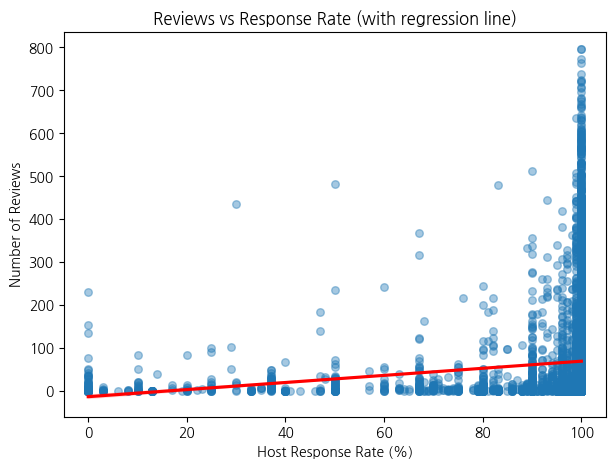

In [25]:
import seaborn as sns

plt.figure(figsize=(7,5))
sns.regplot(x=X, y=Y, scatter_kws={'alpha':0.4, 's':30}, line_kws={'color':'red'})
plt.xlabel("Host Response Rate (%)")
plt.ylabel("Number of Reviews")
plt.title("Reviews vs Response Rate (with regression line)")
plt.show()

In [26]:
import scipy.stats as stats

pearson_r, pearson_p = stats.pearsonr(X, Y)
spearman_r, spearman_p = stats.spearmanr(X, Y)

print(f"Pearson r = {pearson_r:.3f}, p = {pearson_p:.3e}")
print(f"Spearman rho = {spearman_r:.3f}, p = {spearman_p:.3e}")

Pearson r = 0.118, p = 1.884e-32
Spearman rho = 0.213, p = 2.561e-102


In [27]:
import statsmodels.api as sm

X = sm.add_constant(df_non_missing['host_response_rate']) #Ï†àÌé∏ Ï∂îÍ∞Ä
Y = df_non_missing['number_of_reviews']

model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      number_of_reviews   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     141.7
Date:                Sun, 21 Sep 2025   Prob (F-statistic):           1.88e-32
Time:                        14:20:39   Log-Likelihood:                -60144.
No. Observations:                9953   AIC:                         1.203e+05
Df Residuals:                    9951   BIC:                         1.203e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -14.2145      6.754     -2.105      0.035     -27.453      -0.976
host_response_rate     0.8269      0.069     11.903      0.000       0.691       0.963
==============================================================================
Omnibus:                     5446.223   Durbin-Watson:                   1.139
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39054.329
Skew:                           2.601   Prob(JB):                         0.00
Kurtosis:                      11.192   Cond. No.                         643.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Ï∞∏Í≥†)
Ï†àÌé∏ÏùÑ Ï∂îÍ∞ÄÌï¥Ïïº ÌïòÎäî Ïù¥Ïú†  
ÌòÑÏã§Ï†ÅÏúºÎ°ú x=0Ïùº Îïå y=0Ïùº ÌïÑÏöîÍ∞Ä ÏóÜÏùå.  
Ï†àÌé∏ÏùÑ Ìè¨Ìï®ÌïòÎ©¥ Î™®Îç∏Ïù¥ Îç∞Ïù¥ÌÑ∞Ïóê Îçî Ïûò ÎßûÍ≤å ÌöåÍ∑ÄÏÑ†ÏùÑ Í∑∏Î¶¥ Ïàò ÏûàÏùå.  
Ï†àÌé∏ ÏóÜÎäî Î™®Îç∏ÏùÄ ÌäπÏ†ï ÏÉÅÌô©(Î¨ºÎ¶¨Ìïô Î≤ïÏπô Îì±)ÏóêÏÑúÎäî ÎßûÏùÑ Ïàò ÏûàÏßÄÎßå, ÎåÄÎ∂ÄÎ∂ÑÏùò ÏÇ¨Ìöå/ÎπÑÏ¶àÎãàÏä§ Îç∞Ïù¥ÌÑ∞ÏóêÎäî Î∂ÄÏ†ÅÏ†à.

Í≤∞Í≥º Î∂ÑÏÑù
1. p << 0.05 Ïù¥Í∏∞ÎïåÎ¨∏Ïóê ÏùëÎãµÎ•†Ïù¥ ÎÜíÏùÑÏàòÎ°ù Î¶¨Î∑∞Í∞Ä ÎßéÏùÑ Í∞ÄÎä•ÏÑ±ÏùÄ ÏûàÎã§.
2. Í∑∏Îü¨ÎÇò Í∑∏ Ï†ïÎèÑÎäî ÏïΩÌïòÎã§.: Pearson Í∏∞Ï§ÄÏúºÎ°úÎäî Í±∞Ïùò Î¨¥Ïãú Í∞ÄÎä•Ìïú ÏàòÏ§Ä, SpearmanÏùÄ Ï°∞Í∏à Îçî ÌÅ¨ÏßÄÎßå Ïó¨Ï†ÑÌûà 'ÏïΩÌïú ÏÉÅÍ¥Ä'
3. ÏùëÎãµÎ•†Ïù¥ 100%Ïù∏ Í≤ΩÏö∞ÏôÄ Í∞ôÏù¥ ÌäπÏ†ï Íµ¨Í∞ÑÏóê Î™∞Î†§ÏûàÏñ¥ÏÑú ÏÑ†Ìòï Í¥ÄÍ≥ÑÎ°úÎäî Ïûò ÏÑ§Î™ÖÏù¥ ÎêòÏßÄ ÏïäÏùå.
4. ÏùëÎãµÎ•†(host_response_rate) ÌïòÎÇòÎßåÏúºÎ°úÎäî Î¶¨Î∑∞ Ïàò(number_of_reviews) Î≥ÄÎèôÏùÑ 1.4%Î∞ñÏóê ÏÑ§Î™Ö Î™ª Ìï®.

Ï†ïÎ¶¨)ÏùëÎãµÎ•†ÏùÄ ÌÜµÍ≥ÑÏ†ÅÏúºÎ°ú Î¶¨Î∑∞ ÏàòÏôÄ Í¥ÄÎ†®Ïù¥ ÏûàÏßÄÎßå, ÏÑ§Î™ÖÎ†•ÏùÄ Í∑πÎèÑÎ°ú ÎÇÆÎã§. Îî∞ÎùºÏÑú Îã®ÎèÖ Î≥ÄÏàòÎ°úÎäî ÏùòÎØ∏ ÏóÜÏúºÎ©∞, ÏùëÎãµ ÏãúÍ∞ÑÏù¥ÎÇò ÏàòÎùΩÎ•† Îì± Îã§Î•∏ ÏßÄÌëúÏôÄ Ìï®Íªò Î≥¥Îäî Í≤ÉÏù¥ ÌïÑÏöîÌïòÎã§.

##number_of_reviews vs host_response_time
Í∑∏Î£πÎ≥Ñ ÌèâÍ∑† Ï∞®Ïù¥ Í≤ÄÏ†ïÏù¥ Ï†ÅÏ†à
Ï†ïÍ∑úÏÑ± ÌôïÏù∏ ÌõÑ **Kruskal‚ÄìWallis(ÎπÑÎ™®Ïàò)** ÌòπÏùÄ  **ANOVA**

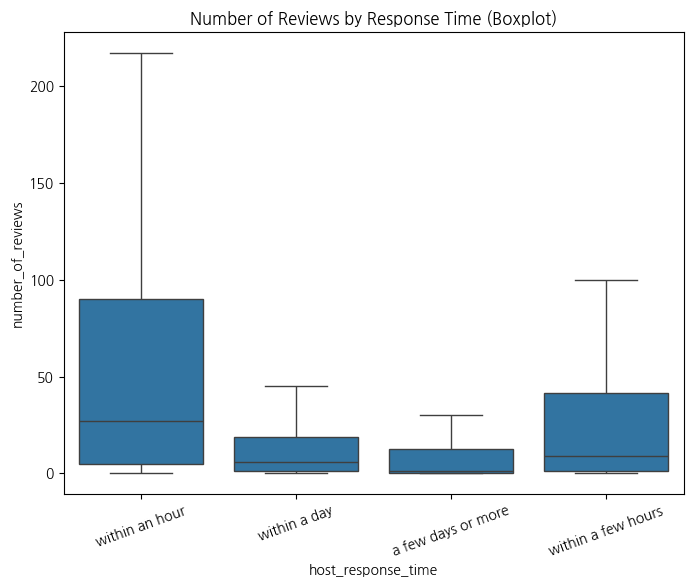

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.boxplot(x='host_response_time', y='number_of_reviews', data=df_non_missing, showfliers=False)
plt.title("Number of Reviews by Response Time (Boxplot)")
plt.xticks(rotation=20)
plt.show()

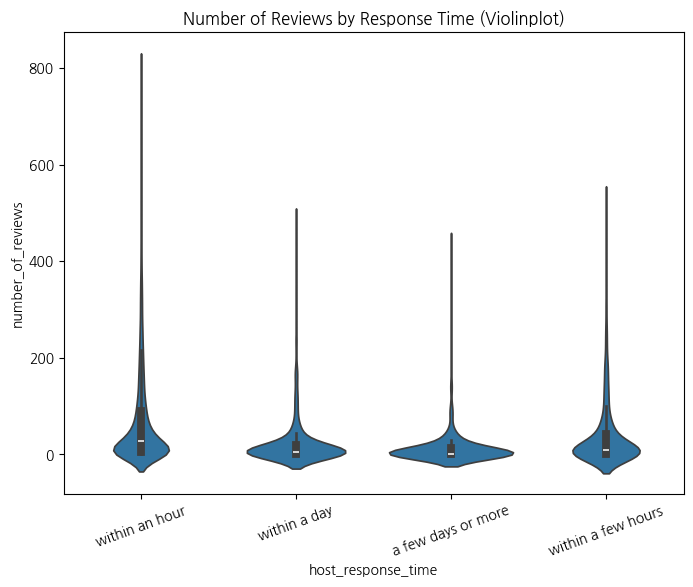

In [29]:
plt.figure(figsize=(8,6))
sns.violinplot(x='host_response_time', y='number_of_reviews', data=df_non_missing, inner="box")
plt.title("Number of Reviews by Response Time (Violinplot)")
plt.xticks(rotation=20)
plt.show()

ÏïûÏÑú ÌôïÏù∏Ìïú ÏÇ∞Ï†êÎèÑÎ≥¥Îã§ Îçî ÌÅ∞ Ïó∞Í¥Ä Í¥ÄÍ≥ÑÎ•º Î≥¥Ïù¥Îäî ÎìØÌïú Ï∞®Ìä∏?!

In [30]:
# Í∑∏Î£πÎ≥Ñ Shapiro-Wilk Í≤ÄÏ†ï (Ï†ïÍ∑úÏÑ±)
print("=== Shapiro-Wilk Ï†ïÍ∑úÏÑ± Í≤ÄÏ†ï ===")
for group, grp_df in df_non_missing.groupby("host_response_time"):
    stat, p = stats.shapiro(grp_df["number_of_reviews"])
    print(f"[{group}] W={stat:.3f}, p={p:.3e}")

print("\n=== Levene Îì±Î∂ÑÏÇ∞ÏÑ± Í≤ÄÏ†ï ===")
# Levene‚Äôs test (Îì±Î∂ÑÏÇ∞ÏÑ±) ‚Üí Ïó¨Îü¨ Í∑∏Î£π ÎèôÏãúÏóê
groups = [grp["number_of_reviews"].values
          for _, grp in df_non_missing.groupby("host_response_time")]
stat, p = stats.levene(*groups)
print(f"Levene‚Äôs test: stat={stat:.3f}, p={p:.3e}")

=== Shapiro-Wilk Ï†ïÍ∑úÏÑ± Í≤ÄÏ†ï ===
[a few days or more] W=0.371, p=1.439e-29
[within a day] W=0.482, p=2.282e-35
[within a few hours] W=0.591, p=1.749e-38
[within an hour] W=0.684, p=1.075e-82

=== Levene Îì±Î∂ÑÏÇ∞ÏÑ± Í≤ÄÏ†ï ===
Levene‚Äôs test: stat=69.462, p=1.888e-44


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8449.
  res = hypotest_fun_out(*samples, **kwds)


Ï†ïÍ∑úÎ∂ÑÌè¨(Shapiro‚ÄìWilk), Îì±Î∂ÑÏÇ∞ÏÑ±(Levene) Î™®Îëê ÎßåÏ°± X -> **Kruskal‚ÄìWallis test**

In [32]:
# Kruskal-Wallis
import scipy.stats as stats

groups = [grp['number_of_reviews'].values
          for _, grp in df_non_missing.groupby('host_response_time')]

statistic, p_value = stats.kruskal(*groups)

print(f"P-Í∞í: {p_value:.3e}")
print(f"Kruskal-Wallis Í≤ÄÏ†ï ÌÜµÍ≥ÑÎüâ: {statistic:.3f}")

P-Í∞í: 7.152e-109
Kruskal-Wallis Í≤ÄÏ†ï ÌÜµÍ≥ÑÎüâ: 503.803


**host_response_time Í∑∏Î£π Í∞Ñ Î¶¨Î∑∞ Ïàò Î∂ÑÌè¨ Ï∞®Ïù¥Í∞Ä ÌÜµÍ≥ÑÏ†ÅÏúºÎ°ú Îß§Ïö∞ Ïú†ÏùòÌï®ÏùÑ ÌôïÏù∏**

##number_of_reviews vs host_acceptance_rate
Îëò Îã§ Ïó∞ÏÜçÌòï ‚Üí 1Î≤àÍ≥º ÎèôÏùº. ÏÑ†ÌòïÌöåÍ∑Ä + Î≥¥Ï°∞Î°ú ÏÉÅÍ¥ÄÎ∂ÑÏÑù

In [33]:
X = df_non_missing['host_acceptance_rate']
Y = df_non_missing['number_of_reviews']


import scipy.stats as stats

pearson_r, pearson_p = stats.pearsonr(X, Y)
spearman_r, spearman_p = stats.spearmanr(X, Y)

print(f"Pearson r = {pearson_r:.3f}, p = {pearson_p:.3e}")
print(f"Spearman rho = {spearman_r:.3f}, p = {spearman_p:.3e}")

Pearson r = 0.157, p = 7.891e-56
Spearman rho = 0.249, p = 2.992e-140


In [34]:
import statsmodels.api as sm

X = sm.add_constant(df_non_missing['host_acceptance_rate']) #Ï†àÌé∏ Ï∂îÍ∞Ä
Y = df_non_missing['number_of_reviews']

model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      number_of_reviews   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     250.9
Date:                Sun, 21 Sep 2025   Prob (F-statistic):           7.89e-56
Time:                        08:36:16   Log-Likelihood:                -60091.
No. Observations:                9953   AIC:                         1.202e+05
Df Residuals:                    9951   BIC:                         1.202e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -13.6091      5.081     -2.678      0.007     -23.569      -3.649
host_acceptance_rate     0.8548      0.054     15.840      0.000       0.749       0.961
==============================================================================
Omnibus:                     5432.918   Durbin-Watson:                   1.111
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39096.420
Skew:                           2.591   Prob(JB):                         0.00
Kurtosis:                      11.211   Cond. No.                         471.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

ÌîºÏñ¥Ïä®, Ïä§ÌîºÏñ¥Îßå: ÏñëÏùò ÏÉÅÍ¥Ä Í¥ÄÍ≥ÑÎ•º ÌôïÏù∏. ÌÜµÍ≥ÑÏ†ÅÏúºÎ°úÎäî Ïú†ÏùòÌïòÏßÄÎßå,   Îç∞Ïù¥ÌÑ∞Í∞Ä ÏõåÎÇô ÌÅ¨Îã§ Î≥¥Îãà ÏûëÏùÄ Ìö®Í≥ºÎèÑ Ïú†ÏùòÌïòÍ≤å Ïû°Ìûå Í≤ÉÏùº Îøê, ÏÑ§Î™ÖÎ†•Ïù¥ ÏïΩ 2.5%Î∞ñÏóê Ïïà Îê®.
Ï¶â, ÏàòÎùΩÎ•† ÌïòÎÇòÎßåÏúºÎ°úÎäî Î¶¨Î∑∞ Ïàò Î≥ÄÎèôÏùÑ Í±∞Ïùò ÏÑ§Î™ÖÌïòÏßÄ Î™ª Ìï®

#Ï§ëÍ∞Ñ Í≤∞Î°†:  
ÏùëÎãµÎ•†, ÏàòÎùΩÎ•†ÏùÄ Îã®Ïùº ÏßÄÌëúÎ°ú Î¶¨Î∑∞ ÏàòÎ•º ÏÑ§Î™ÖÌïòÎäî ÌûòÏù¥ Í∑πÌûà ÏïΩÌïòÎã§.  
ÏùëÎãµÏãúÍ∞ÑÏù¥ÎÇò Ìò∏Ïä§ÌåÖ Í∏∞Í∞Ñ Í∞ôÏùÄ Îã§Î•∏ Î≥ÄÏàòÍπåÏßÄ Ìè¨Ìï®Ìïú Îã§Ï§ë ÌöåÍ∑ÄÎ•º ÎèåÎ†§Î≥¥Îäî Í≤ÉÏù¥ ÌïÑÏöî

#VIF Îã§Ï§ëÍ≥µÏÑ†ÏÑ± ÌôïÏù∏

In [31]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Î∂ÑÏÑùÌï† Î≥ÄÏàòÎì§ (ÏùëÎãµÎ•†, ÏùëÎãµÏãúÍ∞Ñ Ï†êÏàò, Ìò∏Ïä§ÌåÖ ÏàòÎùΩÎ•†)
features = ['host_response_rate', 'host_response_time_score',
            'host_acceptance_rate']

X = df_non_missing[features].copy()
X = sm.add_constant(X)  # Ï†àÌé∏ Ï∂îÍ∞Ä

# VIF Í≥ÑÏÇ∞
vif_df = pd.DataFrame()
vif_df["Variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_df

Variable        VIF
0                     const  45.589229
1        host_response_rate   2.247829
2  host_response_time_score   2.631926
3      host_acceptance_rate   1.981033

Î™®Îì† Í∞íÎì§Ïù¥ 5Ï†ê ÎØ∏ÎßåÏù¥Îùº Îã§Ï§ëÍ≥µÏÑ†ÏÑ± Î¨∏Ï†úÎäî ÏóÜÏùå. Îã§Îßå ÏÉùÍ∞ÅÌï¥Î≥¥Îãà ÎπÑÏä∑Ìïú Î≥ÄÏàò ÎëòÏù¥ ÏûàÏñ¥ÏÑú Í∑∏ Îëò ÎÅºÎ¶¨ Îã§Ïãú VIF ÌôïÏù∏

In [32]:
df_non_missing[['host_response_rate','host_response_time_score']].corr()


host_response_rate  host_response_time_score
host_response_rate                  1.000000                  0.728084
host_response_time_score            0.728084                  1.000000

ÏàòÏπòÎäî ÏûëÍ≤å ÎÇòÏôîÏßÄÎßå.. ÎπÑÏä∑Ìïú ÏàòÏπòÏù¥Í∏∞ÎïåÎ¨∏Ïóê Îëò Ï§ë host_response_rate Îäî Î≥ÄÏàòÎ°úÏç® Î≤ÑÎ¶¨Îäî Í≤ÉÏúºÎ°ú

#Îã§Ï§ë ÌöåÍ∑Ä

In [33]:
# ÎèÖÎ¶ΩÎ≥ÄÏàò
features = ['host_response_time_score',
            'host_acceptance_rate']

X = df_non_missing[features].copy()
X = sm.add_constant(X)   # Ï†àÌé∏ Ï∂îÍ∞Ä

# Ï¢ÖÏÜçÎ≥ÄÏàò
y = df_non_missing['number_of_reviews']

# OLS ÌöåÍ∑ÄÎ™®Îç∏ Ï†ÅÌï©
model = sm.OLS(y, X).fit()

# Í≤∞Í≥º ÏöîÏïΩ
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      number_of_reviews   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     142.0
Date:                Sun, 21 Sep 2025   Prob (F-statistic):           1.52e-61
Time:                        14:28:13   Log-Likelihood:                -60074.
No. Observations:                9953   AIC:                         1.202e+05
Df Residuals:                    9950   BIC:                         1.202e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                      -31.1689      5.939     -5.248      0.000     -42.810     -19.528
host_response_time_score    11.7527      2.066      5.688      0.000       7.702      15.803
host_acceptance_rate         0.5681      0.074      7.698      0.000       0.423       0.713
==============================================================================
Omnibus:                     5423.750   Durbin-Watson:                   1.109
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38969.117
Skew:                           2.586   Prob(JB):                         0.00
Kurtosis:                      11.198   Cond. No.                         562.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#Îã§Ï§ë ÌöåÍ∑ÄÎèÑ Í∞íÏù¥ ÍµâÏû•Ìûà ÎÇÆÍ≤å ÎÇòÏôîÏùå.....
ÏÑ∏ Î≥ÄÏàò Ï§ë Í∞ÄÏû• ÏùòÎØ∏ ÏûàÎçò ```host_response_time```Ïóê ÎåÄÌï¥ Îçî ÍπäÍ≤å ÌååÌó§Ï≥êÎ≥¥Ïûê...

##number_of_reviews vs host_response_time ÏÇ¨ÌõÑ Í≤ÄÏ†ï - Dunn‚Äôs test (ÎπÑÎ™®Ïàò)

In [34]:
!pip install scikit-posthocs


In [35]:
import scikit_posthocs as sp

# Dunn‚Äôs test (Bonferroni Î≥¥Ï†ï)
dunn_result = sp.posthoc_dunn(
    df_non_missing,
    val_col='number_of_reviews',
    group_col='host_response_time',
    p_adjust='bonferroni'
)

dunn_result

a few days or more  within a day  within a few hours  \
a few days or more        1.000000e+00  1.344751e-04        1.669159e-13   
within a day              1.344751e-04  1.000000e+00        9.887923e-04   
within a few hours        1.669159e-13  9.887923e-04        1.000000e+00   
within an hour            6.898771e-54  1.793628e-42        2.481833e-27   

                    within an hour  
a few days or more    6.898771e-54  
within a day          1.793628e-42  
within a few hours    2.481833e-27  
within an hour        1.000000e+00

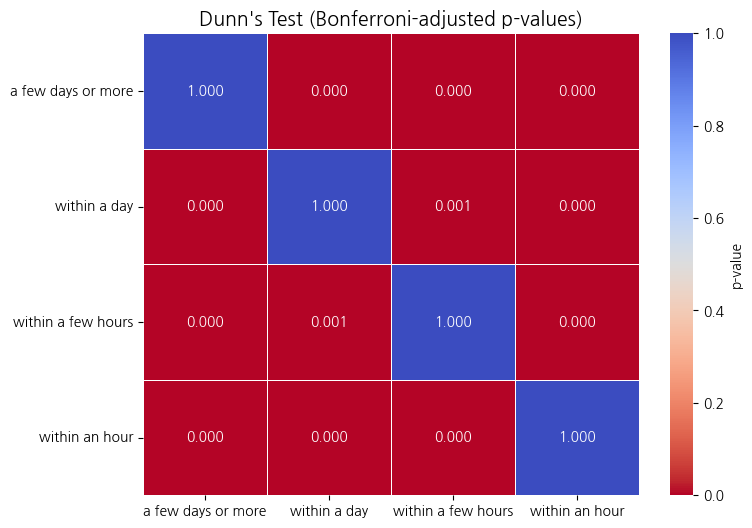

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(
    dunn_result,
    annot=True,          # p-Í∞í Ïà´ÏûêÎ°ú ÌëúÏãú
    fmt=".3f",           # ÏÜåÏàòÏ†ê 3ÏûêÎ¶¨
    cmap="coolwarm_r",   # ÏÉâÏÉÅ (Îπ®Í∞ï-ÌååÎûë Î∞òÏ†Ñ)
    cbar_kws={'label': 'p-value'},
    linewidths=0.5
)
plt.title("Dunn's Test (Bonferroni-adjusted p-values)", fontsize=14)
plt.yticks(rotation=0)
plt.show()

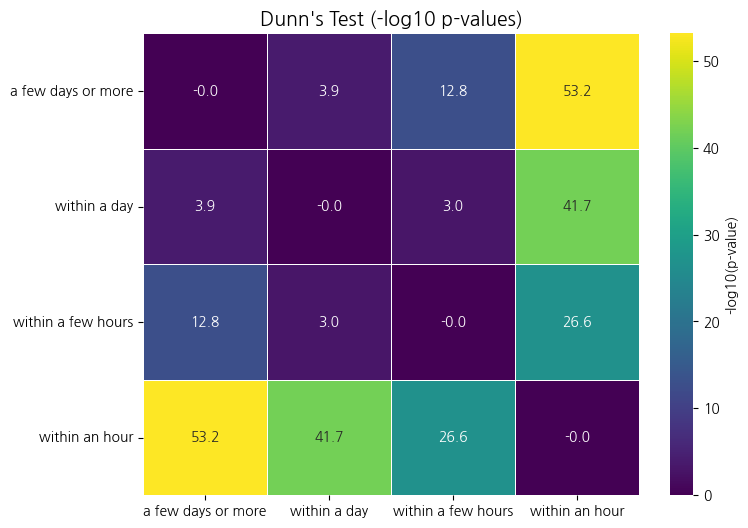

In [37]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# -log10 Î≥ÄÌôò (p=0Ïù¥Î©¥ ÏïÑÏ£º ÏûëÏùÄ Í∞íÏúºÎ°ú ÎåÄÏ≤¥)
log_p = -np.log10(dunn_result.replace(0, 1e-300))

plt.figure(figsize=(8,6))
sns.heatmap(
    log_p,
    annot=True,
    fmt=".1f",
    cmap="viridis",
    cbar_kws={'label': '-log10(p-value)'},
    linewidths=0.5
)
plt.title("Dunn's Test (-log10 p-values)", fontsize=14)
plt.yticks(rotation=0)
plt.show()

‚ÄúDunn‚Äôs test ÏÇ¨ÌõÑÍ≤ÄÏ†ï Í≤∞Í≥º, ÏùëÎãµÏãúÍ∞Ñ Í∑∏Î£π Í∞Ñ Î¶¨Î∑∞ Ïàò Î∂ÑÌè¨Îäî Î™®Îëê ÌÜµÍ≥ÑÏ†ÅÏúºÎ°ú Ïú†ÏùòÌïú Ï∞®Ïù¥Î•º Î≥¥ÏòÄÎã§(p<0.001). ÌäπÌûà within an hour Í∑∏Î£πÏùÄ Îã§Î•∏ Î™®Îì† Í∑∏Î£πÎ≥¥Îã§ Î¶¨Î∑∞ ÏàòÍ∞Ä Ïú†ÏùòÌïòÍ≤å ÎßéÏïòÎã§

Í∑∏Î†áÎã§Î©¥ within an hourÎäî Ïñ¥Îñ§ Í∑∏Î£πÏùºÏßÄ Í∂ÅÍ∏àÌï¥ÏßÑÎã§... ÌèâÏ†êÎèÑ ÎÜíÏùÄÍ±¥ÏßÄ Ï∂îÍ∞Ä ÌôïÏù∏Ìï¥Î≥¥Ïûê

In [41]:
df_non_missing['review_scores_rating'].isnull().sum()

np.int64(1049)

In [42]:
df_non_missing['review_scores_rating'].shape

(9953,)

/tmp/ipython-input-601046247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-601046247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-601046247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-601046247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-601046247.py:22: FutureWarning: 

Passing `pa

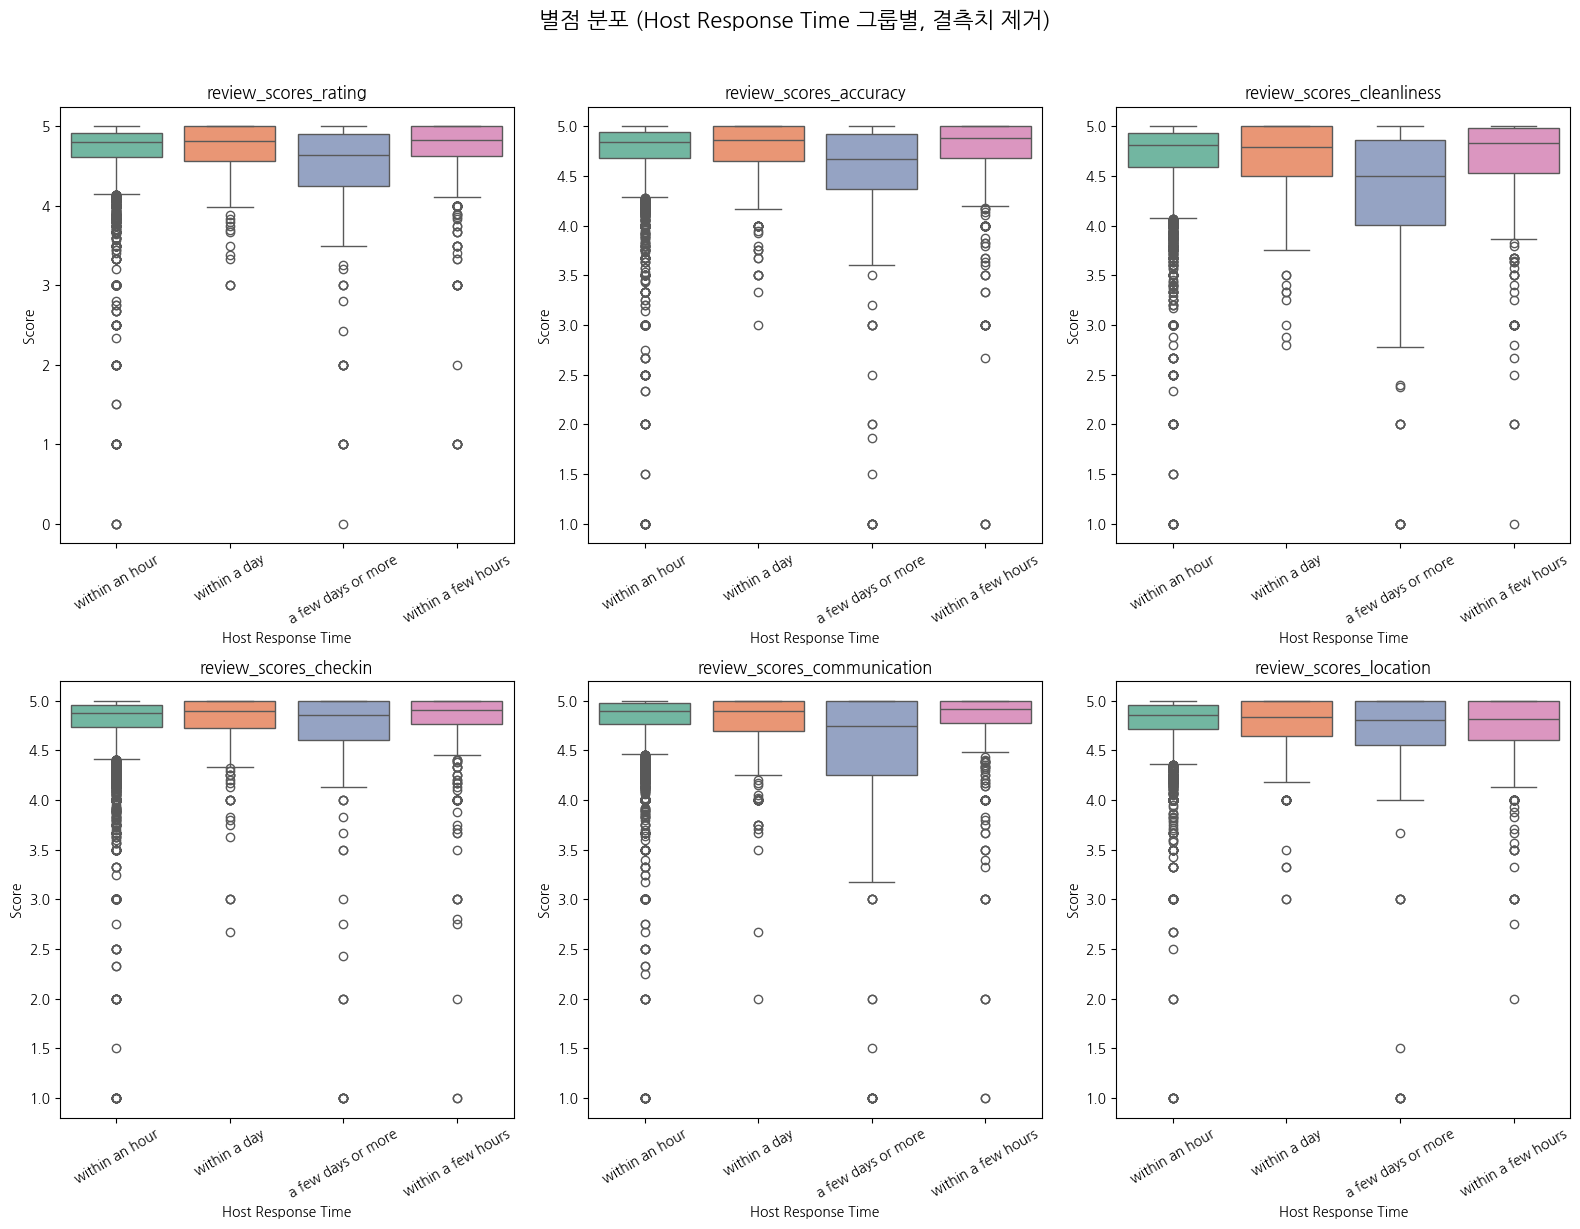

In [43]:
#Í∑∏Î£πÎ≥Ñ Î≥ÑÏ†êÏùÑ Î∞ïÏä§ ÌîåÎ°ØÏúºÎ°ú ÏãúÍ∞ÅÌôî. (Î≥ÄÏàòÎ≥Ñ Í≤∞Ï∏°Ïπò Ï†úÍ±∞Ìï®)

import matplotlib.pyplot as plt
import seaborn as sns

# ÏãúÍ∞ÅÌôîÌï† Ïª¨Îüº Î™©Î°ù
score_fields = [
    "review_scores_rating",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location"
]

plt.figure(figsize=(16, 12))

for i, col in enumerate(score_fields, 1):
    plt.subplot(2, 3, i)

    # Í∞Å Î≥ÄÏàòÎ≥Ñ Í≤∞Ï∏°Ïπò Ï†úÍ±∞ ÌõÑ Î∞ïÏä§ÌîåÎ°Ø
    sns.boxplot(
        data=df_non_missing.dropna(subset=[col]),
        x="host_response_time",
        y=col,
        palette="Set2"
    )

    plt.title(col, fontsize=12)
    plt.xlabel("Host Response Time")
    plt.ylabel("Score")
    plt.xticks(rotation=30)

plt.suptitle("Î≥ÑÏ†ê Î∂ÑÌè¨ (Host Response Time Í∑∏Î£πÎ≥Ñ, Í≤∞Ï∏°Ïπò Ï†úÍ±∞)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()



a few days or moreÏù¥ Î∞ïÏä§Í∞Ä Îã§Î•∏ Í∑∏Î£πÏóê ÎπÑÌï¥ Í∏∫
- Ìï¥ÏÑù: Í≤åÏä§Ìä∏Í∞Ä Ìò∏Ïä§Ìä∏Ïùò ÏùëÎãµÏùÑ Î©∞Ïπ† Ïù¥ÏÉÅ Í∏∞Îã§Î†§Ïïº ÌïòÎäî Í≤ΩÏö∞, ÎßåÏ°±ÎèÑÍ∞Ä Îì§Ïë•ÎÇ†Ïë•
Í∑ºÎç∞ within an hourÎèÑ Î∞ïÏä§ Ïô∏Ïóê Ï∞çÌûå Ï†êÎì§Ïù¥ ÎÑàÎ¨¥ÎÑàÎ¨¥ ÎßéÏùå
- Ìï¥ÏÑù: Ïù¥ Í∑∏Î£π ÎÇ¥ÏóêÏÑúÎèÑ **Í∑πÎã®Ï†ÅÏù∏ Í≤ΩÌóò(Îß§Ïö∞ Î∂àÎßåÏ°± or Îß§Ïö∞ ÎßåÏ°±)**ÏùÑ Ìïú Í≤åÏä§Ìä∏Í∞Ä Ï†ÅÏßÄ ÏïäÏïòÏùå.

Ï¢ÖÌï©: **Îπ†Î•∏ ÏùëÎãµ(1ÏãúÍ∞Ñ Ïù¥ÎÇ¥)**Ïù¥ 'ÌèâÍ∑†Ï†Å'ÏúºÎ°úÎäî Ï¢ãÏùÄ ÌèâÍ∞ÄÏôÄ Ïó∞Í≤∞ÎêòÏßÄÎßå,  
Ïò§ÌûàÎ†§ Í∏∞ÎåÄÏπòÍ∞Ä ÎÜíÏïÑÏÑú Ï°∞Í∏àÎßå Î∂àÌé∏Ìï¥ÎèÑ ÎÇÆÏùÄ Ï†êÏàòÎ•º Ï£ºÎäî Í≤åÏä§Ìä∏Í∞Ä ÍΩ§ ÏûàÏóàÏùÑÏßÄÎèÑ?  
Î∞òÎåÄÎ°ú ÎäêÎ¶∞ ÏùëÎãµ Í∑∏Î£πÏùÄ Ï†ÑÎ∞òÏ†ÅÏúºÎ°ú Í∏∞ÎåÄÏπòÍ∞Ä ÎÇÆÏïÑ Î∂ÑÏÇ∞Ïù¥ ÌÅ¥ ÏàòÎèÑ?

In [47]:
summary = df_non_missing.groupby("host_response_time")[score_fields].agg(["mean", "std"]) #median, count

summary.round(2)

review_scores_rating       review_scores_accuracy        \
                                   mean   std                   mean   std   
host_response_time                                                           
a few days or more                 4.29  1.03                   4.35  0.99   
within a day                       4.71  0.35                   4.75  0.33   
within a few hours                 4.68  0.53                   4.73  0.48   
within an hour                     4.70  0.39                   4.75  0.36   

                   review_scores_cleanliness       review_scores_checkin  \
                                        mean   std                  mean   
host_response_time                                                         
a few days or more                      4.21  0.97                  4.52   
within a day                            4.66  0.39                  4.80   
within a few hours                      4.65  0.51                  4.79   
within an hour                          4.69  0.39                  4.78   

                         review_scores_communication        \
                     std                        mean   std   
host_response_time                                           
a few days or more  0.93                        4.35  1.04   
within a day        0.31                        4.77  0.35   
within a few hours  0.40                        4.78  0.43   
within an hour      0.34                        4.80  0.33   

                   review_scores_location        
                                     mean   std  
host_response_time                               
a few days or more                   4.56  0.83  
within a day                         4.75  0.30  
within a few hours                   4.72  0.36  
within an hour                       4.79  0.28

In [46]:
summary_stacked = summary.stack(level=0)   # Î≥ÄÏàòÎ™ÖÏùÑ ÏÑ∏Î°úÏ∂ïÏúºÎ°ú
display(summary_stacked)

/tmp/ipython-input-1364143555.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  summary_stacked = summary.stack(level=0)   # Î≥ÄÏàòÎ™ÖÏùÑ ÏÑ∏Î°úÏ∂ïÏúºÎ°ú


mean  median       std  \
host_response_time                                                           
a few days or more review_scores_accuracy       4.347669   4.670  0.992652   
                   review_scores_checkin        4.523620   4.860  0.928049   
                   review_scores_cleanliness    4.212761   4.500  0.969565   
                   review_scores_communication  4.346074   4.750  1.043814   
                   review_scores_location       4.564785   4.810  0.829767   
                   review_scores_rating         4.287988   4.640  1.030438   
within a day       review_scores_accuracy       4.751468   4.860  0.328359   
                   review_scores_checkin        4.802264   4.900  0.305174   
                   review_scores_cleanliness    4.661866   4.795  0.388987   
                   review_scores_communication  4.765100   4.900  0.352606   
                   review_scores_location       4.754055   4.835  0.304740   
                   review_scores_rating         4.707114   4.820  0.353507   
within a few hours review_scores_accuracy       4.727021   4.880  0.478530   
                   review_scores_checkin        4.786323   4.910  0.397168   
                   review_scores_cleanliness    4.645024   4.830  0.512434   
                   review_scores_communication  4.784596   4.920  0.429558   
                   review_scores_location       4.721173   4.820  0.364312   
                   review_scores_rating         4.679684   4.830  0.529562   
within an hour     review_scores_accuracy       4.748842   4.840  0.361263   
                   review_scores_checkin        4.782918   4.880  0.341223   
                   review_scores_cleanliness    4.691727   4.810  0.393378   
                   review_scores_communication  4.802662   4.900  0.333582   
                   review_scores_location       4.791471   4.860  0.281703   
                   review_scores_rating         4.698802   4.800  0.391910   

                                                count  
host_response_time                                     
a few days or more review_scores_accuracy         163  
                   review_scores_checkin          163  
                   review_scores_cleanliness      163  
                   review_scores_communication    163  
                   review_scores_location         163  
                   review_scores_rating           164  
within a day       review_scores_accuracy         402  
                   review_scores_checkin          402  
                   review_scores_cleanliness      402  
                   review_scores_communication    402  
                   review_scores_location         402  
                   review_scores_rating           402  
within a few hours review_scores_accuracy         631  
                   review_scores_checkin          631  
                   review_scores_cleanliness      631  
                   review_scores_communication    631  
                   review_scores_location         631  
                   review_scores_rating           632  
within an hour     review_scores_accuracy        7684  
                   review_scores_checkin         7684  
                   review_scores_cleanliness     7685  
                   review_scores_communication   7685  
                   review_scores_location        7684  
                   review_scores_rating          7706

In [48]:
# ÌïÑÏöîÌïú Ìå®ÌÇ§ÏßÄ
from scipy.stats import kruskal
import scikit_posthocs as sp
import numpy as np
import pandas as pd

group_col = "host_response_time"

kw_results = {}          # Í∞Å Ìï≠Î™©Ïùò Kruskal‚ÄìWallis p-Í∞í
dunn_results = {}        # Í∞Å Ìï≠Î™©Ïùò Dunn‚Äôs test p-Í∞í ÌñâÎ†¨(DataFrame)
winner_summary = []      # Ìï≠Î™©Î≥Ñ ‚ÄúÏµúÍ≥† Í∑∏Î£π‚Äù ÌåêÏ†ï ÏöîÏïΩ

for col in score_fields:
    # Ìï¥Îãπ Ìï≠Î™©Ïùò Í≤∞Ï∏°ÏπòÎßå Ï†úÍ±∞
    sub = df_non_missing[[group_col, col]].dropna()
    # Í∑∏Î£πÎ≥Ñ Í∞í Î¶¨Ïä§Ìä∏
    groups = [g[col].values for _, g in sub.groupby(group_col)]
    labels = list(sub[group_col].unique())

    # 1) Kruskal‚ÄìWallis
    stat, p = kruskal(*groups)
    kw_results[col] = p

    # 2) Dunn‚Äôs test (Bonferroni Î≥¥Ï†ï)
    dunn = sp.posthoc_dunn(sub, val_col=col, group_col=group_col, p_adjust="bonferroni")
    dunn.index.name = dunn.columns.name = group_col
    dunn_results[col] = dunn

    # 3) ‚ÄúÍ∞ÄÏû• ÎÇòÏùÄ Í∑∏Î£π‚Äù ÌåêÏ†ï Î°úÏßÅ (Ï§ëÏïôÍ∞í Í∏∞Ï§Ä + Î™®Îì† ÏåçÍ≥º Ïú†Ïùò Ï∞®Ïù¥)
    med = sub.groupby(group_col)[col].median().sort_values(ascending=False)
    top = med.index[0]                         # Ï§ëÏïôÍ∞íÏù¥ Í∞ÄÏû• ÌÅ∞ Í∑∏Î£π
    # topÏù¥ ÎÇòÎ®∏ÏßÄ Î™®Îì† Í∑∏Î£πÎ≥¥Îã§ Ïú†ÏùòÌïòÍ≤å ÎÜíÏùÄÍ∞Ä?
    # (ÏåçÎ≥Ñ p<0.05 Ïù¥Î©¥ÏÑú top Ï§ëÏïôÍ∞í >= ÏÉÅÎåÄ Ï§ëÏïôÍ∞í)
    is_top_sig = True
    for other in med.index[1:]:
        p_pair = dunn.loc[top, other] if top in dunn.index and other in dunn.columns else dunn.loc[other, top]
        if not (p_pair < 0.05 and med.loc[top] >= med.loc[other]):
            is_top_sig = False
            break

    winner_summary.append({
        "metric": col,
        "kw_pvalue": p,
        "top_by_median": top,
        "top_median": float(med.loc[top]),
        "is_top_significantly_higher_vs_all": is_top_sig,
    })

# 4) ÏöîÏïΩ ÌÖåÏù¥Î∏î
summary_df = pd.DataFrame(winner_summary).sort_values("metric")
summary_df["kw_pvalue"] = summary_df["kw_pvalue"].map(lambda x: f"{x:.2e}")
summary_df


metric kw_pvalue       top_by_median  top_median  \
1       review_scores_accuracy  1.70e-09  within a few hours        4.88   
3        review_scores_checkin  7.58e-07  within a few hours        4.91   
2    review_scores_cleanliness  3.62e-11  within a few hours        4.83   
4  review_scores_communication  1.02e-09  within a few hours        4.92   
5       review_scores_location  6.15e-03      within an hour        4.86   
0         review_scores_rating  1.00e-08  within a few hours        4.83   

   is_top_significantly_higher_vs_all  
1                               False  
3                               False  
2                               False  
4                               False  
5                               False  
0                               False

In [49]:
import numpy as np

relative_summary = []

for col in score_fields:
    sub = df_non_missing[[group_col, col]].dropna()
    dunn = dunn_results[col]

    counts = {grp: 0 for grp in dunn.index}
    for g1 in dunn.index:
        for g2 in dunn.columns:
            if g1 != g2:
                if dunn.loc[g1, g2] < 0.05:
                    # g1Ïù¥ g2Î≥¥Îã§ Ï§ëÏïôÍ∞íÏù¥ ÎÜíÎã§Î©¥ Ïπ¥Ïö¥Ìä∏ +1
                    if sub.groupby(group_col)[col].median()[g1] > sub.groupby(group_col)[col].median()[g2]:
                        counts[g1] += 1
    relative_summary.append({"metric": col, **counts})

pd.DataFrame(relative_summary)

metric  a few days or more  within a day  \
0         review_scores_rating                   0             1   
1       review_scores_accuracy                   0             1   
2    review_scores_cleanliness                   0             1   
3        review_scores_checkin                   0             2   
4  review_scores_communication                   0             1   
5       review_scores_location                   0             0   

   within a few hours  within an hour  
0                   2               1  
1                   2               1  
2                   1               1  
3                   2               0  
4                   2               1  
5                   0               1

------


> Î≥ÄÏàòÎ≥ÑÎ°ú Î¶¨Î∑∞ Ïàò Ï∞®Ïù¥Í∞Ä ÏûàÎÉêÎ•º ÌÜµÍ≥ÑÏ†ÅÏúºÎ°ú ÌôïÏù∏ÌñàÏùå. Îã§ÏùåÎ∂ÄÌÑ∞Îäî ‚ÄúÎ¶¨Î∑∞Í∞Ä Ï†ÅÏùÄ Ìò∏Ïä§Ìä∏Î•º ÏãùÎ≥ÑÌï† Ïàò ÏûàÎÉê‚ÄùÎùºÎäî ÏòàÏ∏°Î¨∏Ï†úÎ°ú Î∞îÍøîÏÑú ÏÉùÍ∞Å

**Ïö¥ÏòÅ Ï†ÑÎûµ(users ÎåÄÏãúÎ≥¥Îìú ÎÖ∏Ï∂ú Î∞©Ìñ•)** Ïóê Ïó∞Í≤∞ Í∞ÄÎä•

#Î∂ÄÍ∞Ä ÏãúÍ∞ÅÌôî
Î¶¨Î∑∞ ÏàòÏôÄ Ïó∞Í¥ÄÏù¥ ÏûàÎäî Îã§Î•∏ Îç∞Ïù¥ÌÑ∞Î°ú Î¨¥ÏóáÏù¥ ÏûàÏùÑÍπå?

<Figure size 1200x600 with 0 Axes>

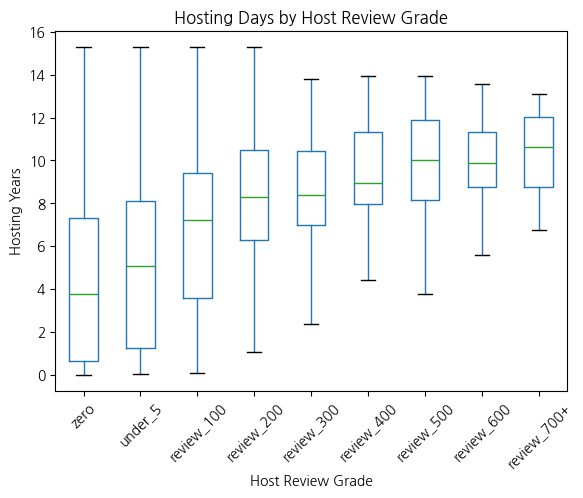

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
df_clean.boxplot(
    column="hosting_years",
    by="host_review_grade",
    grid=False,
    showfliers=False   # Ïù¥ÏÉÅÏπò Ï†ê Ïïà Î≥¥Ïù¥Í≤å Ìï¥ÏÑú Ï†ÑÏ≤¥ Î∂ÑÌè¨Í∞Ä Îçî Ïûò Î≥¥Ïù¥Í≤å
)
plt.title("Hosting Days by Host Review Grade")
plt.suptitle("")  # Í∏∞Î≥∏ ÌÉÄÏù¥ÌãÄ Ï†úÍ±∞
plt.xlabel("Host Review Grade")
plt.ylabel("Hosting Years")
plt.xticks(rotation=45)
plt.show()

Î¶¨Î∑∞Í∞Ä Ï†ÅÏùÄ Ìò∏Ïä§Ìä∏Îäî Ïö¥ÏòÅ Í∏∞Í∞ÑÏùò Ï∞®Ïù¥Í∞Ä ÌÅ¨Îã§ ‚Üí ‚ÄúÏö¥ÏòÅ Í∏∞Í∞ÑÎßå Í∏∏Îã§Í≥† Î¶¨Î∑∞Í∞Ä ÏåìÏù¥ÏßÄÎäî ÏïäÎäîÎã§.‚Äù  
Î¶¨Î∑∞Í∞Ä ÎßéÏùÄ Ìò∏Ïä§Ìä∏Îäî Ïö¥ÏòÅ Í∏∞Í∞ÑÏùò Ï∞®Ïù¥Í∞Ä ÏÉÅÎåÄÏ†ÅÏúºÎ°ú ÏûëÎã§ ‚Üí Î¶¨Î∑∞ ÏÑ±Í≥ºÍ∞Ä Ï¢ãÏùÄ Ìò∏Ïä§Ìä∏Îì§ÏùÄ Í∏∞Í∞Ñ Ìå®ÌÑ¥Ïù¥ ÎπÑÏä∑ÌïòÎã§..?

<Figure size 1200x600 with 0 Axes>

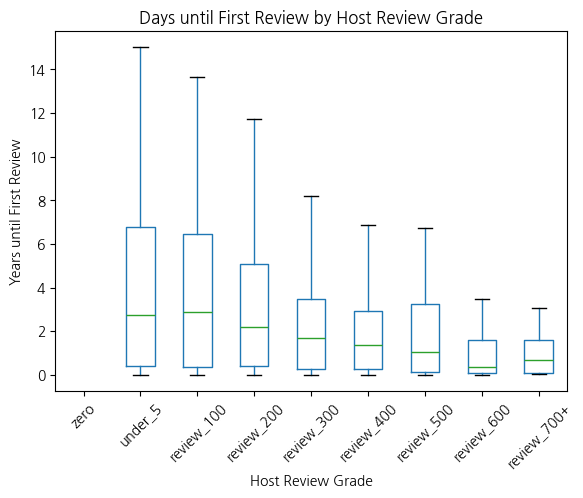

In [31]:
plt.figure(figsize=(12,6))
df_clean.boxplot(
    column="til_first_review_years",
    by="host_review_grade",
    grid=False,
    showfliers=False   # Í∑πÎã®Ïπò Ï†úÏô∏ÌïòÎ©¥ Ï†ÑÎ∞òÏ†Å Î∂ÑÌè¨Í∞Ä Ïûò Î≥¥ÏûÑ
)
plt.title("Days until First Review by Host Review Grade")
plt.suptitle("")  # Í∏∞Î≥∏ ÌÉÄÏù¥ÌãÄ Ï†úÍ±∞
plt.xlabel("Host Review Grade")
plt.ylabel("Years until First Review")
plt.xticks(rotation=45)
plt.show()

review_500+ Í∑∏Î£πÏúºÎ°ú Í∞àÏàòÎ°ù Î∞ïÏä§Í∞Ä Í∏âÍ≤©Ìûà ÏßßÏïÑÏßê (Ï≤´ Î¶¨Î∑∞ Î∞õÍ∏∞ÍπåÏßÄ Í∏∞Í∞ÑÏù¥ ÏßßÏùå)
Ï¶â, Ï≤´ Î¶¨Î∑∞Î•º Îπ®Î¶¨ Î∞õÏùÄ Ìò∏Ïä§Ìä∏Í∞Ä Ïû•Í∏∞Ï†ÅÏúºÎ°úÎèÑ Î¶¨Î∑∞Î•º Îçî ÎßéÏù¥ ÏåìÎäî Í≤ΩÌñ•Ïù¥ Í¥ÄÏ∞∞Îê®.
###Ìò∏Ïä§ÌåÖÏùÑ ÏãúÏûëÌïòÍ≥† Îã®Í∏∞Í∞Ñ ÎÇ¥Ïóê Ï≤´ Î¶¨Î∑∞Î•º Î∞õÎäî Í≤ÉÏù¥ Îçî ÎßéÏùÄ Î¶¨Î∑∞Î•º Ï∂ïÏ†ÅÌïòÍ≤å ÌïòÎ©∞Í≤∞Íµ≠ Îçî Ïò§Îûú Í∏∞Í∞Ñ Ìò∏Ïä§ÌåÖÏùÑ Ìï† Ïàò ÏûàÎäî ÎèôÎ†•Ïù¥ ÎêòÎäî Í≤ÉÏùÄ ÏïÑÎãêÏßÄ??

GPT says
Î¶¨Î∑∞ ÏàòÍ∞Ä ÎßéÏùÑÏàòÎ°ù Ï≤´ Î¶¨Î∑∞ÍπåÏßÄ Í±∏Î¶∞ Í∏∞Í∞ÑÏù¥ ÏßßÍ≥† ÏùºÍ¥ÄÏ†Å.

Í≥†ÏÑ±Í≥º Ìò∏Ïä§Ìä∏Îì§Ïùò Í≥µÌÜµ Ìå®ÌÑ¥ÏùÄ: ‚ÄúÏ≤´ Î¶¨Î∑∞ ‚â§ 1ÎÖÑ‚Äù.

Ï≤´ Î¶¨Î∑∞ÍπåÏßÄ ÏßÄÏó∞Îêú Ìò∏Ïä§Ìä∏Îäî Ïû•Í∏∞Ï†ÅÏúºÎ°úÎèÑ Ï†ÄÏÑ±Í≥ºÍµ∞Ïùº Í∞ÄÎä•ÏÑ±Ïù¥ ÎÜíÏùå.


In [56]:
df_non_missing['number_of_reviews'].isnull().sum()

#Î™áÎÖÑ Í±∏Î†∏ÎäîÏßÄ Í∞íÏù¥ ÏóÜÎäî Í≤ΩÏö∞Í∞Ä 1051Í∞úÎÇò ÏûàÏùå....

np.int64(0)

In [58]:
# 1) Spearman ÏÉÅÍ¥Ä (Î¶¨Î∑∞ ‚â•1 & til_first_review_years Ï°¥Ïû¨)
from scipy import stats

df_corr = df_non_missing[
    (df_non_missing['number_of_reviews'] > 0) &
    (df_non_missing['til_first_review_years'].notna())
].copy()

rho, p = stats.spearmanr(
    df_corr['number_of_reviews'],
    df_corr['til_first_review_years']
)
print(f"Spearman rho = {rho:.3f}, p = {p:.3e}, n = {len(df_corr)}")


Spearman rho = -0.130, p = 4.549e-35, n = 8902


ÏùåÏùò ÏÉÅÍ¥Ä ‚Üí Ï≤´ Î¶¨Î∑∞ÍπåÏßÄ Í±∏Î¶∞ ÏãúÍ∞ÑÏù¥ ÏßßÏùÑÏàòÎ°ù, Ïû•Í∏∞Ï†ÅÏúºÎ°ú Î¶¨Î∑∞ ÏàòÍ∞Ä ÎßéÎã§. Îã§Îßå ÏÉÅÍ¥ÄÍ≥ÑÏàò Ï†àÎåÄÍ∞íÏù¥ 0.13Ïù¥ÎØÄÎ°ú, Í¥ÄÍ≥ÑÎäî ÏïΩÌïòÎã§.
ÌëúÎ≥∏ ÏàòÍ∞Ä ÌÅ¨Í∏∞(n=8,902) ÎïåÎ¨∏Ïóê ÏïÑÏ£º ÏûëÏùÄ Ï∞®Ïù¥ÎèÑ ÌÜµÍ≥ÑÏ†ÅÏúºÎ°úÎäî Í∞ïÌïòÍ≤å Ïú†Ïùò. (Î®ºÎßêÏù¥ÎÉê..)

In [59]:
# 2) df_cleanÏóêÏÑú "Î¶¨Î∑∞Îäî ÏûàÎäîÎç∞ ÎÇ†ÏßúÍ∞Ä ÏóÜÏñ¥ til_first_review_yearsÍ∞Ä NaN"Ïù∏ ÏºÄÏù¥Ïä§ Ïπ¥Ïö¥Ìä∏
mask_weird = (
    (df_clean['number_of_reviews'] > 0) &
    (df_clean['til_first_review_years'].isna())
)
n_weird = mask_weird.sum()
n_total = len(df_clean)
print(f"Î¶¨Î∑∞>0 & til_first_review_years=NaN: {n_weird}Í∞ú ({n_weird/n_total:.2%})")

# Ï∞∏Í≥†: Î¶¨Î∑∞Í∞Ä 0Ïù¥Í≥† til_first_review_yearsÍ∞Ä NaNÏù∏ Ï†ïÏÉÅ ÏºÄÏù¥Ïä§ÎèÑ Í∞ôÏù¥ ÌôïÏù∏
mask_zero = (
    (df_clean['number_of_reviews'] == 0) &
    (df_clean['til_first_review_years'].isna())
)
print(f"Î¶¨Î∑∞=0 & til_first_review_years=NaN: {mask_zero.sum()}Í∞ú")

# ÌïÑÏöîÌïòÎ©¥ Ïñ¥Îñ§ ÌñâÎì§Ïù∏ÏßÄ ÏÉòÌîå ÌôïÏù∏
# display(df_clean.loc[mask_weird].head())


Î¶¨Î∑∞>0 & til_first_review_years=NaN: 0Í∞ú (0.00%)
Î¶¨Î∑∞=0 & til_first_review_years=NaN: 1497Í∞ú


#ÏπúÍµ¨ says  


üìå ÏßÄÍ∏àÍπåÏßÄ ÎÇòÏò® Í∑ºÍ±∞

ÏùëÎãµ ÏãúÍ∞Ñ

Dunn‚Äôs test Í≤∞Í≥º ‚Üí ÏùëÎãµÏù¥ Îπ†Î•ºÏàòÎ°ù Î¶¨Î∑∞ ÏàòÍ∞Ä Ïú†ÏùòÌïòÍ≤å ÎßéÏùå.

Ï¶â, ‚ÄúÌïòÎ£® ÏïàÏóê‚Äù (ÌäπÌûà within an hour) ÏùëÎãµÌïòÎäî Í≤å Î¶¨Î∑∞ ÏÑ±Ïû•Ïóê Ïú†Î¶¨.

Ï≤´ Î¶¨Î∑∞ÍπåÏßÄ Í±∏Î¶∞ Í∏∞Í∞Ñ

Spearman ÏÉÅÍ¥Ä(rho=-0.13, p‚â™0.001) ‚Üí Ï≤´ Î¶¨Î∑∞Í∞Ä Îπ®Î¶¨ Îã¨Î¶∞ Ìò∏Ïä§Ìä∏ÏùºÏàòÎ°ù Î¶¨Î∑∞ ÏàòÍ∞Ä ÎßéÏùå.

Î∞ïÏä§ÌîåÎ°ØÏóêÏÑúÎèÑ Ï≤´ Î¶¨Î∑∞ ‚â§ 1ÎÖÑ Ïù¥ÎÇ¥ ÌôïÎ≥¥Ìïú Ìò∏Ïä§Ìä∏Í∞Ä Ïû•Í∏∞Ï†ÅÏúºÎ°ú Í≥†ÏÑ±Í≥º Í∑∏Î£πÏúºÎ°ú Í∞ÄÎäî Í≤ΩÌñ• ÌôïÏù∏.

üëâ Í≤∞Î°†: Îπ†Î•∏ ÏùëÎãµ + Îπ†Î•∏ Ï≤´ Î¶¨Î∑∞ ÌôïÎ≥¥ = Ïû•Í∏∞ Î¶¨Î∑∞ ÏÑ±Ïû•Ïùò ÌïµÏã¨ Ìå®ÌÑ¥

üìä Î™©Ìëú Ïû¨ÏÑ§Ï†ï (Ïù¥Ï†ú Îßâ ÏãúÏûëÌïòÎäî Ìò∏Ïä§Ìä∏ ÌÇ§Ïö∞Í∏∞)

ÌñâÎèô Í∞ÄÏù¥ÎìúÎùºÏù∏

ÏùëÎãµ Î™©Ìëú: Î¨¥Ï°∞Í±¥ ÌïòÎ£® Ïù¥ÎÇ¥(ideally within an hour).

Ï≤´ Î¶¨Î∑∞ Î™©Ìëú: Í∞ÄÎä•ÌïòÎã§Î©¥ Î™á Îã¨ Ïù¥ÎÇ¥, Îä¶Ïñ¥ÎèÑ 1ÎÖÑ ÏïàÏóê Ï≤´ Î¶¨Î∑∞ ÌôïÎ≥¥.

Ïö¥ÏòÅ Ï†ÑÎûµ ÏòàÏãú

Ïã†ÏûÖ Ìò∏Ïä§Ìä∏ÏóêÍ≤ê ÏûêÎèôÌôî Î©îÏãúÏßÄÎ°ú ‚ÄúÏ≤´ Î¨∏ÏùòÎäî Î¨¥Ï°∞Í±¥ 1ÏãúÍ∞Ñ ÏïàÏóê ÎãµÌïòÏÑ∏Ïöî‚Äù ÍµêÏú°.

Í∞ÄÍ≤© ÌîÑÎ°úÎ™®ÏÖò, Ïã†Í∑ú Í≤åÏä§Ìä∏ Ïú†Ïπò Ïù¥Î≤§Ìä∏, Î¶¨Î∑∞ Ïù∏ÏÑºÌã∞Î∏å ‚Üí Ï≤´ Î¶¨Î∑∞ ÌôïÎ≥¥ ÏÜçÎèÑÎ•º ÏïûÎãπÍπÄ.

üìå Î®∏Ïã†Îü¨Îãù Í¥ÄÏ†ê Ïó∞Í≤∞

Î®∏Ïã†Îü¨Îãù Î™®Îç∏ÏùÑ Ïì∞Î©¥:

Î¶¨Î∑∞ Î∂ÄÏ°± ÏúÑÌóòÍµ∞ ÏòàÏ∏°

low_review_flag (under_5 Ïó¨Î∂Ä) Î∂ÑÎ•ò Î™®Îç∏ ‚Üí Î¶¨Î∑∞ Î∂ÄÏ°±Ìï† Í∞ÄÎä•ÏÑ± ÎÜíÏùÄ Ïã†ÏûÖ Ìò∏Ïä§Ìä∏ ÎØ∏Î¶¨ ÏãùÎ≥Ñ.

Ï†ïÏ±Ö ÏãúÎÆ¨Î†àÏù¥ÏÖò

Î™®Îç∏Ïóê ‚ÄúÏùëÎãµÏãúÍ∞Ñ=within an hour‚Äù vs ‚Äúa few days‚Äù ÎÑ£Ïñ¥ÏÑú ÏòàÏ∏° ÎπÑÍµê ‚Üí ÏùëÎãµ Í∞úÏÑ†Ïù¥ Î¶¨Î∑∞ ÏÑ±Ïû• ÌôïÎ•†Ïóê ÏñºÎßàÎÇò Í∏∞Ïó¨ÌïòÎäîÏßÄ Ï∂îÏ†ï Í∞ÄÎä•.

‚úÖ Ï†ïÎ¶¨

ÎÑ§Í∞Ä ÏÑ§Ï†ïÌïú Í≥®:
‚ÄúÏùëÎãµÏùÑ ÌïòÎ£® Ïù¥ÎÇ¥Î°ú Ïú†ÏßÄÌïòÍ≥†, Ï≤´ Î¶¨Î∑∞Î•º ÏµúÎåÄÌïú Îπ®Î¶¨ Î∞õÍ≤å ÌïòÎäî Í≤É‚Äù

Ïù¥Í±¥ ÏßÄÍ∏àÍπåÏßÄÏùò Î∂ÑÏÑù Í≤∞Í≥ºÎûë ÏôÑÏ†ÑÌûà ÏùºÏπòÌïòÍ≥†, Ïã§Ï†ú Airbnb Ïö¥ÏòÅÏ†ÑÎûµÏóêÎèÑ Î∂ÄÌï©Ìï©ÎãàÎã§.

Î®∏Ïã†Îü¨ÎãùÏùÄ Ïù¥Í±∏ Í∞úÎ≥Ñ Ìò∏Ïä§Ìä∏ Îã®ÏúÑÎ°ú ÌôïÎ•†ÌôîÌï¥ÏÑú ‚ÄúÏù¥ Ìò∏Ïä§Ìä∏Îäî Î¶¨Î∑∞ Î∂ÄÏ°± ÏúÑÌóòÏù¥ ÎÜíÎã§ ‚Üí Î∂ÄÏä§ÌåÖ ÎåÄÏÉÅ‚Äù Ïù¥Î†áÍ≤å Ïì∞Îäî Í±∞ÏòàÏöî.

In [62]:
#----------------

In [64]:
#----------------

In [66]:
#----------------

#‚èØ ‚èØ ‚èØ ‚èØ ‚èØ ‚èØ ‚èØ ‚èØ ‚èØ ‚èØ

Ïó¨Í∏∞ÏÑú ÏùºÎã® til_first_review_years Ïù¥Îûë host_review_gradedÏùÑ Í≤ÄÏ†ï

Îã® host_review_grade == "zero" & til_first_review_daysÍ∞Ä NaNÏù∏ Í≤ΩÏö∞ Ï†úÏô∏

In [32]:
# 'zero' Í∑∏Î£πÏù¥Î©¥ÏÑú Ï≤´ Î¶¨Î∑∞ÏùºÏàò Í≤∞Ï∏°ÏπòÏù∏ Ìñâ Ï†úÍ±∞
mask = ~((df_clean['host_review_grade'] == 'zero') & (df_clean['til_first_review_years'].isna()))
df_valid = df_clean[mask].copy()

print("ÏõêÎûò Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞:", df_clean.shape)
print("ÌïÑÌÑ∞ÎßÅ ÌõÑ Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞:", df_valid.shape)

# Îã§Ïãú Í∑∏Î£πÎ≥ÑÎ°ú til_first_review_days vs host_review_grade Í≤ÄÏ†ï
import scipy.stats as stats

data = df_valid[['til_first_review_years', 'host_review_grade']].dropna()

groups = []
valid_labels = []
for name, grp in data.groupby('host_review_grade'):
    vals = grp['til_first_review_years'].values
    if len(vals) > 0:
        groups.append(vals)
        valid_labels.append(name)

print("Í≤ÄÏ†ïÏóê ÏÇ¨Ïö©Îêú Í∑∏Î£π:", valid_labels)

if len(groups) >= 2:
    anova_stat, anova_p = stats.f_oneway(*groups)
    print("\nANOVA Í≤∞Í≥º")
    print(f"F-statistic: {anova_stat:.3f}, p-value: {anova_p:.3e}")

    kw_stat, kw_p = stats.kruskal(*groups)
    print("\nKruskal-Wallis Í≤∞Í≥º")
    print(f"H-statistic: {kw_stat:.3f}, p-value: {kw_p:.3e}")
else:
    print("‚ö†Ô∏è Ïú†Ìö®Ìïú Í∑∏Î£πÏù¥ 2Í∞ú ÎØ∏ÎßåÏù¥Îùº ÌÜµÍ≥Ñ Í≤ÄÏ†ïÏùÑ Ìï† Ïàò ÏóÜÏäµÎãàÎã§.")


ÏõêÎûò Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: (11446, 81)
ÌïÑÌÑ∞ÎßÅ ÌõÑ Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: (9949, 81)
Í≤ÄÏ†ïÏóê ÏÇ¨Ïö©Îêú Í∑∏Î£π: ['under_5', 'review_100', 'review_200', 'review_300', 'review_400', 'review_500', 'review_600', 'review_700+']

ANOVA Í≤∞Í≥º
F-statistic: 43.207, p-value: 1.604e-60

Kruskal-Wallis Í≤∞Í≥º
H-statistic: 221.716, p-value: 2.852e-44


/tmp/ipython-input-1714500222.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, grp in data.groupby('host_review_grade'):


In [34]:
#number_of_reviewsÎûë til_first_review_years Í∞ÑÏùò ÏÉÅÍ¥Ä Í¥ÄÍ≥Ñ Í≤ÄÏ†ï


# number_of_reviews > 0 Ïù∏ Îç∞Ïù¥ÌÑ∞Îßå Ï∂îÏ∂ú
df_corr = df_clean[(df_clean['number_of_reviews'] > 0)][['number_of_reviews', 'til_first_review_years']].dropna()

# ÌîºÏñ¥Ïä® ÏÉÅÍ¥ÄÍ≥ÑÏàò (ÏÑ†Ìòï Í¥ÄÍ≥Ñ)
pearson_r, pearson_p = stats.pearsonr(df_corr['number_of_reviews'], df_corr['til_first_review_years'])
print("Pearson ÏÉÅÍ¥ÄÎ∂ÑÏÑù Í≤∞Í≥º")
print(f"r = {pearson_r:.3f}, p-value = {pearson_p:.3e}")

# Ïä§ÌîºÏñ¥Îßå ÏàúÏúÑ ÏÉÅÍ¥ÄÍ≥ÑÏàò (ÎπÑÏÑ†Ìòï¬∑ÏàúÏúÑ Í∏∞Î∞ò)
spearman_r, spearman_p = stats.spearmanr(df_corr['number_of_reviews'], df_corr['til_first_review_years'])
print("\nSpearman ÏÉÅÍ¥ÄÎ∂ÑÏÑù Í≤∞Í≥º")
print(f"rho = {spearman_r:.3f}, p-value = {spearman_p:.3e}")




#ÏÉÅÍ¥ÄÍ≥ÑÏàò ÌÅ¨Í∏∞ ÏûêÏ≤¥Îäî Îß§Ïö∞ ÏïΩÌï® (‚Äì0.1 ~ ‚Äì0.2 ÏàòÏ§Ä) ‚Üí ÏÑ§Î™ÖÎ†•ÏùÄ ÎÜíÏßÄ ÏïäÏùå.
#ÌïòÏßÄÎßå p-valueÍ∞Ä Îß§Ïö∞ ÏûëÏïÑÏÑú ‚ÄúÏö∞Ïó∞Ïù¥ ÏïÑÎãò‚ÄùÏùÄ ÌôïÏã§.
#Ìï¥ÏÑù: ÏàôÏÜåÎ•º Ïö¥ÏòÅÌïòÎã§Í∞Ä Î¶¨Î∑∞Î•º Îπ®Î¶¨ Î∞õÏùÄ Ìò∏Ïä§Ìä∏ÏùºÏàòÎ°ù Ïû•Í∏∞Ï†ÅÏúºÎ°ú Î¶¨Î∑∞ ÏàòÍ∞Ä ÎßéÏù¥ ÏåìÏù¥Îäî Í≤ΩÌñ•Ïù¥ ÏûàÎã§~

Pearson ÏÉÅÍ¥ÄÎ∂ÑÏÑù Í≤∞Í≥º
r = -0.173, p-value = 1.468e-67

Spearman ÏÉÅÍ¥ÄÎ∂ÑÏÑù Í≤∞Í≥º
rho = -0.110, p-value = 5.999e-28


In [36]:
import pandas as pd
import scipy.stats as stats

results = []

# Î¶¨Î∑∞Í∞Ä 1Í∞ú Ïù¥ÏÉÅÏù∏ Îç∞Ïù¥ÌÑ∞Îßå ÏÇ¨Ïö©
df_sub = df_clean[df_clean['number_of_reviews'] > 0].copy()

for grade, grp in df_sub.groupby("host_review_grade"):
    data = grp[['number_of_reviews', 'til_first_review_years']].dropna()
    if len(data) > 5:  # ÌëúÎ≥∏ ÎÑàÎ¨¥ ÏûëÏùÄ Í∑∏Î£π Ï†úÏô∏
        pearson_r, pearson_p = stats.pearsonr(data['number_of_reviews'], data['til_first_review_years'])
        spearman_r, spearman_p = stats.spearmanr(data['number_of_reviews'], data['til_first_review_years'])
        results.append({
            "host_review_grade": grade,
            "n": len(data),
            "Pearson r": round(pearson_r, 3),
            "Pearson p": f"{pearson_p:.2e}",
            "Spearman rho": round(spearman_r, 3),
            "Spearman p": f"{spearman_p:.2e}"
        })

results_df = pd.DataFrame(results)
results_df


/tmp/ipython-input-3634293653.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for grade, grp in df_sub.groupby("host_review_grade"):


host_review_grade     n  Pearson r Pearson p  Spearman rho Spearman p
0           under_5  1886     -0.013  5.75e-01        -0.020   3.94e-01
1        review_100  5881     -0.048  2.32e-04        -0.022   8.92e-02
2        review_200  1176     -0.073  1.18e-02        -0.052   7.21e-02
3        review_300   537     -0.052  2.29e-01        -0.054   2.09e-01
4        review_400   270     -0.183  2.48e-03        -0.159   8.93e-03
5        review_500   112     -0.117  2.21e-01        -0.075   4.30e-01
6        review_600    56     -0.085  5.34e-01        -0.166   2.20e-01
7       review_700+    31     -0.051  7.83e-01         0.417   1.97e-02

Î¶¨Î∑∞Í∞Ä ÎßéÏùÑÏàòÎ°ù Ï≤´ Î¶¨Î∑∞ÍπåÏßÄ Í±∏Î¶∞ ÏãúÍ∞ÑÏù¥ ÏïΩÍ∞Ñ ÏßßÏïÑÏßÄÎäî Í≤ΩÌñ•ÏùÄ ÏûàÏúºÎÇò, Ìö®Í≥º ÌÅ¨Í∏∞Îäî Îß§Ïö∞ ÏïΩÌï®
p-valueÍ∞Ä ÏûëÏùÄ Í∑∏Î£πÏùÄ Ïú†ÏùòÌïòÎã§Í≥† Î≥º Ïàò ÏûàÏßÄÎßå, ÏÉÅÍ¥ÄÍ≥ÑÏàò ÏûêÏ≤¥Í∞Ä ÏûëÏúºÎØÄÎ°ú ÏÑ§Î™ÖÎ†•ÏùÄ Í±∞Ïùò ÏóÜÏùå
ÌäπÌûà review_400 Í∑∏Î£πÏóêÏÑú ÏùåÏùò ÏÉÅÍ¥ÄÏù¥ Í∞ÄÏû• ÎöúÎ†∑ÌïòÍ≤å ÎÇòÌÉÄÎÇ®.
Í∑πÎã®Ï†Å Í≥†Î¶¨Î∑∞ Í∑∏Î£π(700+)ÏùÄ ÌëúÎ≥∏Ïù¥ Ï†ÅÏñ¥ ÌäπÏù¥Ìïú Ìå®ÌÑ¥(ÏñëÏùò ÏÉÅÍ¥Ä)Ïù¥ ÎÇòÌÉÄÎÇ¨ÏßÄÎßå Ïã†Î¢∞ÎèÑÎäî ÎÇÆÏùå.


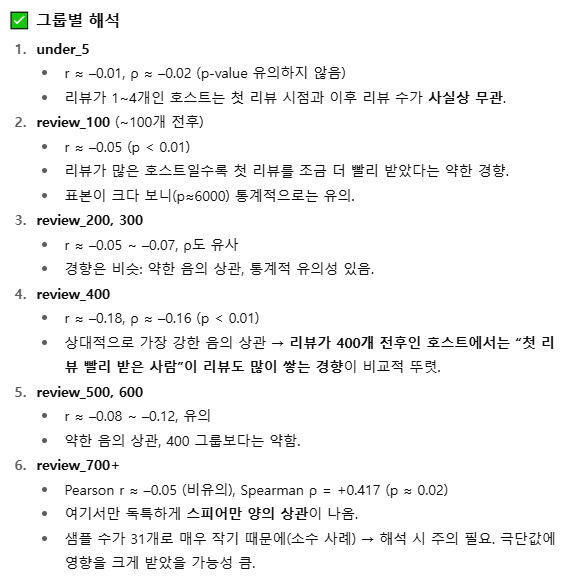

In [7]:
# ÏùëÎãµÏãúÍ∞Ñ Ï†êÏàòÌôî (Îπ†Î•ºÏàòÎ°ù ÎÜíÏùÄ Ï†êÏàò)
resp_time_score_map = {
    "within an hour": 4,
    "within a few hours": 3,
    "within a day": 2,
    "a few days or more": 1
}

df_clean["host_response_time_score"] = df_clean["host_response_time"].map(resp_time_score_map)


In [22]:
check_response_time = df['host_response_time'].isnull().sum()
check_response_rate = df['host_response_rate'].isnull().sum()
check_time_rate =  (df['host_response_time'].isnull() & df['host_response_rate'].isnull()).sum()
check_acceptance_rate = df['host_acceptance_rate'].isnull().sum()

print("Í≤∞Ï∏°Ïπò ÌôïÏù∏")
print(f"ÏùëÎãµ ÏãúÍ∞Ñ Í≤∞Ï∏°Ïπò: {check_response_time}")
print(f"ÏùëÎãµ ÎπÑÏú® Í≤∞Ï∏°Ïπò: {check_response_rate}")
print(f"ÏùëÎãµ ÏãúÍ∞Ñ&ÎπÑÏú® Í≤∞Ï∏°Ïπò: {check_time_rate}")
print(f"ÏàòÎùΩÏú® Í≤∞Ï∏°Ïπò: {check_acceptance_rate}")

Í≤∞Ï∏°Ïπò ÌôïÏù∏
ÏùëÎãµ ÏãúÍ∞Ñ Í≤∞Ï∏°Ïπò: 1446
ÏùëÎãµ ÎπÑÏú® Í≤∞Ï∏°Ïπò: 1446
ÏùëÎãµ ÏãúÍ∞Ñ&ÎπÑÏú® Í≤∞Ï∏°Ïπò: 1446
ÏàòÎùΩÏú® Í≤∞Ï∏°Ïπò: 805


/tmp/ipython-input-2603762227.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('host_review_grade')[cols_to_check]


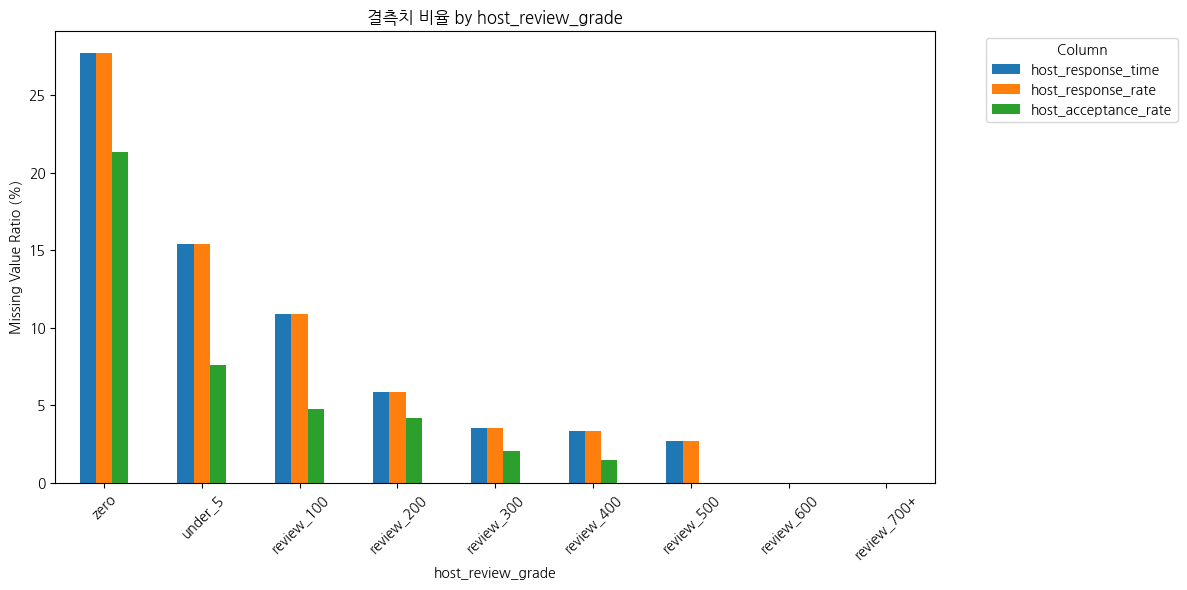

In [23]:
import matplotlib.pyplot as plt

# Í∑∏Î£πÎ≥Ñ Í≤∞Ï∏°Ïπò ÎπÑÏú® Í≥ÑÏÇ∞
cols_to_check = ['host_response_time', 'host_response_rate', 'host_acceptance_rate']

# Í∞Å Í∑∏Î£πÎ≥Ñ Í≤∞Ï∏°Ïπò Ïàò / Ï†ÑÏ≤¥ Ïàò
group_nulls = (
    df_clean
    .groupby('host_review_grade')[cols_to_check]
    .apply(lambda x: x.isnull().mean() * 100)   # ÎπÑÏú®(%)
)

# ÏãúÍ∞ÅÌôî
group_nulls.plot(kind='bar', figsize=(12,6))
plt.ylabel("Missing Value Ratio (%)")
plt.title("Í≤∞Ï∏°Ïπò ÎπÑÏú® by host_review_grade")
plt.xticks(rotation=45)
plt.legend(title="Column", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

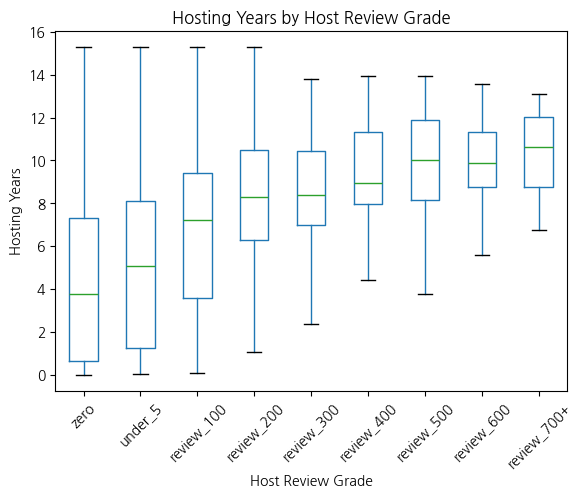

In [39]:
order = ["zero","under_5","review_100","review_200","review_300",
         "review_400","review_500","review_600","review_700+"]

tmp = (
    df_clean[["host_review_grade", "hosting_years"]]
    .dropna()
    .copy()
)
tmp["host_review_grade"] = pd.Categorical(tmp["host_review_grade"], categories=order, ordered=True)

plt.figure(figsize=(10,6))
ax = tmp.boxplot(column="hosting_years", by="host_review_grade",
                 grid=False, showfliers=False)
plt.title("Hosting Years by Host Review Grade")
plt.suptitle("")  # pandas Í∏∞Î≥∏ ÏÉÅÎã® ÌÉÄÏù¥ÌãÄ Ï†úÍ±∞
plt.xlabel("Host Review Grade")
plt.ylabel("Hosting Years")
plt.xticks(rotation=45)
plt.show()

TypeError: 'value' must be an instance of str or bytes, not a float

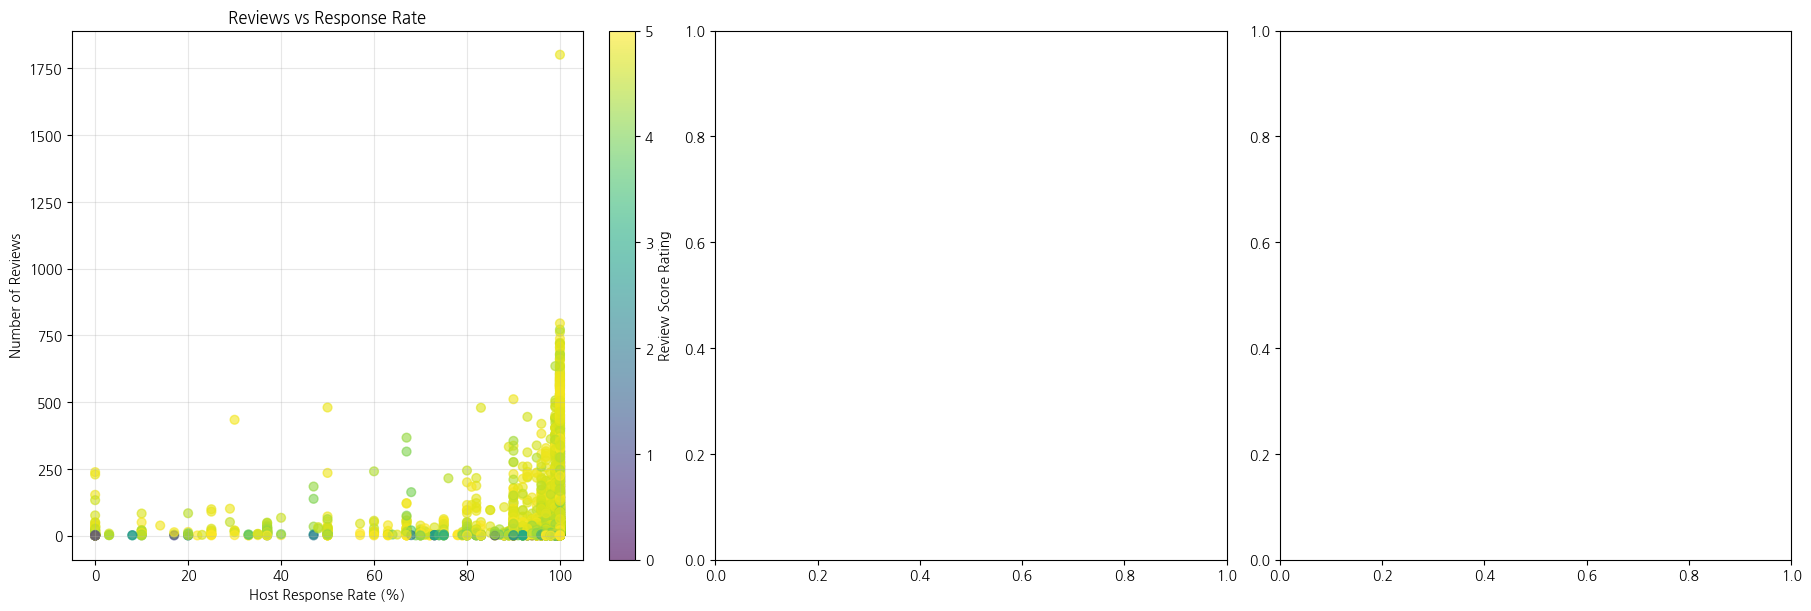

In [15]:
# ÏÇ∞Ï†êÎèÑ (Í∞ÄÎ°úÏ∂ï=ÏùëÎãµÎ•†/ÏùëÎãµÏãúÍ∞Ñ/ÏàòÎùΩÎ•†, ÏÑ∏Î°úÏ∂ï=Î¶¨Î∑∞ Ïàò)

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# (a) ÏùëÎãµÎ•† vs Î¶¨Î∑∞Ïàò
sc0 = axes[0].scatter(
    df_clean['host_response_rate'],
    df_clean['number_of_reviews'],
    c=df_clean['review_scores_rating'],
    cmap='viridis',
    alpha=0.6,
    s=40
)
fig.colorbar(sc0, ax=axes[0], label='Review Score Rating')
axes[0].set_xlabel('Host Response Rate (%)')
axes[0].set_ylabel('Number of Reviews')
axes[0].set_title('Reviews vs Response Rate')
axes[0].grid(True, alpha=0.3)


# (b) ÏùëÎãµÏãúÍ∞Ñ Î¨∏ÏûêÏó¥ vs Î¶¨Î∑∞Ïàò
sc1 = axes[1].scatter(
    df_clean['host_response_time'],
    df_clean['number_of_reviews'],
    c=df_clean['review_scores_rating'],
    cmap='viridis',
    alpha=0.6,
    s=40
)
fig.colorbar(sc1, ax=axes[1], label='Review Score Rating')
axes[1].set_xlabel('Host Response Time')
axes[1].set_ylabel('Number of Reviews')
axes[1].set_title('Reviews vs Response Time')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(
    ['within an hour','within a few hours','within a day','a few days or more']
)
axes[1].set_xticklabels(
    ['within an hour','within a few hours','within a day','a few days or more'],
    rotation=15
)

# (c) ÏàòÎùΩÎ•† vs Î¶¨Î∑∞Ïàò
sc2 = axes[2].scatter(
    df_clean['host_acceptance_rate'],
    df_clean['number_of_reviews'],
    c=df_clean['review_scores_rating'],
    cmap='viridis',
    alpha=0.6,
    s=40
)
fig.colorbar(sc2, ax=axes[2], label='Review Score Rating')
axes[2].set_xlabel('Host Acceptance Rate (%)')
axes[2].set_ylabel('Number of Reviews')
axes[2].set_title('Reviews vs Acceptance Rate')
axes[2].grid(True, alpha=0.3)

plt.show()

In [6]:
df_clean.describe()

id     scrape_id                   last_scraped  \
count  1.144600e+04  1.144600e+04                          11446   
mean   4.359394e+17  2.023782e+13  2024-02-11 23:36:05.787174400   
min    3.884000e+03  2.023062e+13            2023-06-24 00:00:00   
25%    2.679793e+07  2.023122e+13            2023-12-20 00:00:00   
50%    5.435901e+07  2.024033e+13            2024-03-25 00:00:00   
75%    8.936214e+17  2.024033e+13            2024-03-25 00:00:00   
max    1.119467e+18  2.024033e+13            2024-03-26 00:00:00   
std    4.495003e+17  4.129187e+09                            NaN   

            host_id                     host_since  host_response_rate  \
count  1.144600e+04                          11446        10000.000000   
mean   1.952985e+08  2017-08-26 09:48:31.829460224           95.966800   
min    3.128000e+03            2008-09-23 00:00:00            0.000000   
25%    2.320863e+07            2014-11-01 06:00:00          100.000000   
50%    1.090892e+08            2016-12-30 00:00:00          100.000000   
75%    3.804714e+08            2020-12-16 00:00:00          100.000000   
max    5.685152e+08            2024-03-23 00:00:00          100.000000   
std    1.934857e+08                            NaN           15.142458   

       host_acceptance_rate  host_listings_count  host_total_listings_count  \
count          10641.000000         11446.000000               11446.000000   
mean              91.487360            21.551372                  37.146165   
min                0.000000             0.000000                   0.000000   
25%               96.000000             2.000000                   3.000000   
50%              100.000000             6.000000                   9.000000   
75%              100.000000            21.000000                  28.000000   
max              100.000000          2452.000000                5679.000000   
std               20.532961            68.604070                 218.460690   

       neighbourhood_group_cleansed  ...  license  \
count                           0.0  ...      0.0   
mean                            NaN  ...      NaN   
min                             NaN  ...      NaN   
25%                             NaN  ...      NaN   
50%                             NaN  ...      NaN   
75%                             NaN  ...      NaN   
max                             NaN  ...      NaN   
std                             NaN  ...      NaN   

       calculated_host_listings_count  \
count                    11446.000000   
mean                        15.582037   
min                          1.000000   
25%                          2.000000   
50%                          6.000000   
75%                         17.000000   
max                         96.000000   
std                         21.688780   

       calculated_host_listings_count_entire_homes  \
count                                 11446.000000   
mean                                     12.787524   
min                                       0.000000   
25%                                       1.000000   
50%                                       3.000000   
75%                                      13.000000   
max                                      96.000000   
std                                      20.728529   

       calculated_host_listings_count_private_rooms  \
count                                  11446.000000   
mean                                       2.036956   
min                                        0.000000   
25%                                        0.000000   
50%                                        0.000000   
75%                                        1.000000   
max                                       59.000000   
std                                        6.530952   

       calculated_host_listings_count_shared_rooms  reviews_per_month  \
count                                 11446.000000        9949.000000   
mean                                      0.6340

In [7]:
df_clean.to_csv("Airbnb_clean.csv", index=False, encoding="utf-8-sig")

In [10]:
#Ìò∏Ïä§ÌåÖ ÏãúÏûë Ïù¥ÌõÑ Ï≤´ Î¶¨Î∑∞ Î∞õÍ∏∞ÍπåÏßÄÏùò Í∏∞Í∞Ñ(years Í∏∞Ï§Ä)
# Í∑∏Î£πÎ≥Ñ ÌèâÍ∑†Í≥º Ï§ëÏïôÍ∞í Í≥ÑÏÇ∞
result = df_clean.groupby("host_review_grade")["til_first_review_years"].agg(["mean", "median"])

result

/tmp/ipython-input-2759599601.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df_clean.groupby("host_review_grade")["til_first_review_years"].agg(["mean", "median"])


mean    median
host_review_grade                    
zero                    NaN       NaN
under_5            3.781236  2.740589
review_100         3.714425  2.888433
review_200         2.907027  2.114990
review_300         2.102313  1.648186
review_400         1.914042  1.330595
review_500         1.779114  0.997947
review_600         1.070060  0.347707
review_700+        1.010797  0.662560

/tmp/ipython-input-2813575544.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = filtered.groupby("host_review_grade")["til_first_review_years"].count()


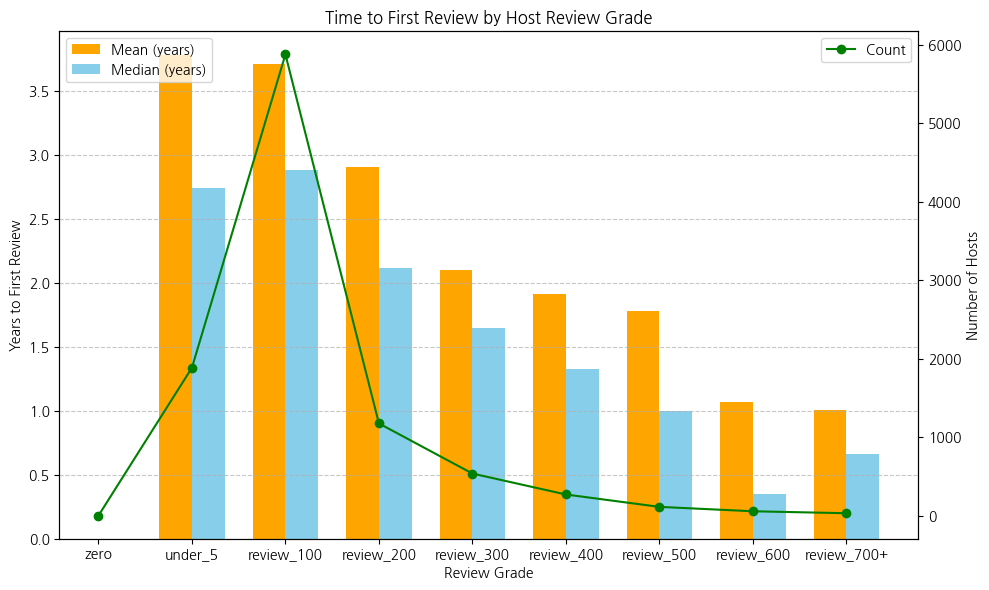

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
bar_width = 0.35
x = range(len(result))

# 1Ô∏è‚É£ Í∏∞Î≥∏ ÎßâÎåÄÏ∞®Ìä∏ (ÌèâÍ∑†/Ï§ëÏïôÍ∞í)
plt.bar([i - bar_width/2 for i in x], result["mean"],
        width=bar_width, label="Mean (years)", color="orange")
plt.bar([i + bar_width/2 for i in x], result["median"],
        width=bar_width, label="Median (years)", color="skyblue")

plt.xticks(x, result.index)
plt.xlabel("Review Grade")
plt.ylabel("Years to First Review")
plt.title("Time to First Review by Host Review Grade")
plt.legend(loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# 2Ô∏è‚É£ Î≥¥Ï°∞ yÏ∂ï Ï∂îÍ∞ÄÌï¥ÏÑú ÎùºÏù∏Ï∞®Ìä∏ Í∑∏Î¶¨Í∏∞
ax1 = plt.gca()                # ÌòÑÏû¨ axis Í∞ÄÏ†∏Ïò§Í∏∞
ax2 = ax1.twinx()              # Î≥¥Ï°∞ yÏ∂ï ÏÉùÏÑ±
counts = filtered.groupby("host_review_grade")["til_first_review_years"].count()
ax2.plot(x, counts, marker="o", color="green", label="Count")
ax2.set_ylabel("Number of Hosts")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

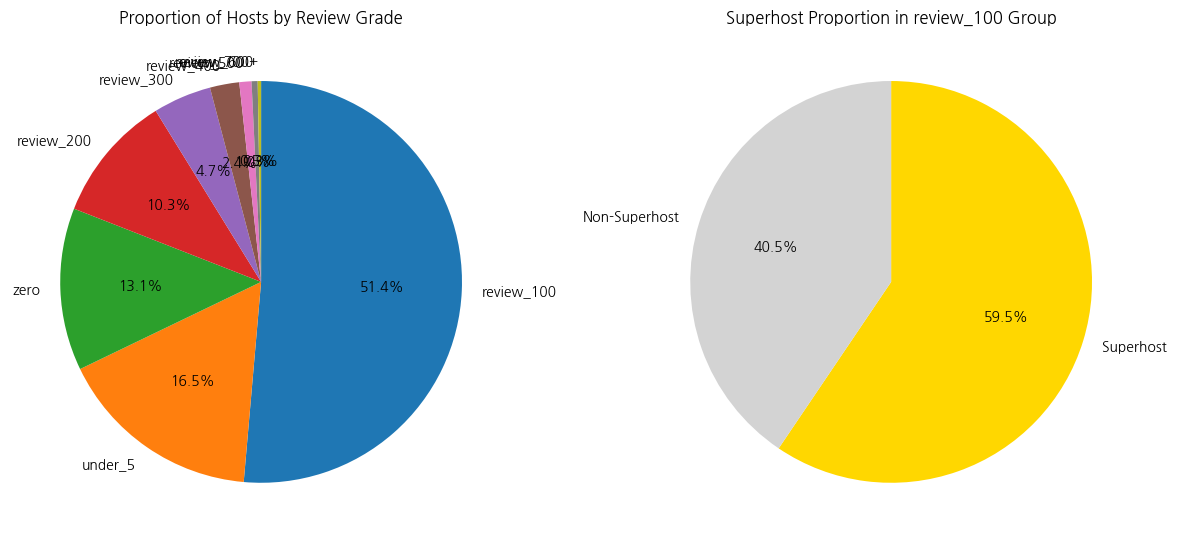

In [21]:
# Í∑∏Î£πÎ≥Ñ Ìò∏Ïä§Ìä∏ Ïàò Í≥ÑÏÇ∞
group_counts = df_clean["host_review_grade"].value_counts()

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.pie(group_counts,
        labels=group_counts.index,
        autopct="%.1f%%",
        startangle=90,
        counterclock=False)
plt.title("Proportion of Hosts by Review Grade")

# review_100 Í∑∏Î£π ÎÇ¥ ÏäàÌçºÌò∏Ïä§Ìä∏ ÎπÑÏú®
review100 = df_clean[df_clean["host_review_grade"] == "review_100"]
superhost_counts = review100["host_is_superhost"].value_counts()

plt.subplot(1,2,2)
plt.pie(superhost_counts,
        labels=["Superhost","Non-Superhost"],
        autopct="%.1f%%",
        colors=["gold","lightgrey"],
        startangle=90,
        counterclock=False)
plt.title("Superhost Proportion in review_100 Group")

plt.tight_layout()
plt.show()

In [16]:
#zero Í∑∏Î£π Ïô∏Ïùò Í∞Å Í∑∏Î£πÎ≥Ñ ÌÜµÍ≥Ñ ÌôïÏù∏
filtered = df_clean[df_clean["host_review_grade"] != "zero"]

# Í∑∏Î£πÎ≥Ñ til_first_review_days Î∂ÑÌè¨ ÏöîÏïΩ
reviewdays_pergroup = filtered.groupby("host_review_grade")["til_first_review_days"].describe()

reviewdays_pergroup

/tmp/ipython-input-3492800118.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reviewdays_pergroup = filtered.groupby("host_review_grade")["til_first_review_days"].describe()


count         mean          std     min     25%     50%  \
host_review_grade                                                             
zero                  0.0          NaN          NaN     NaN     NaN     NaN   
under_5            1886.0  1381.096501  1331.638576   -49.0  152.50  1001.0   
review_100         5881.0  1356.693590  1263.228845 -1737.0  136.00  1055.0   
review_200         1176.0  1061.791667  1022.391978  -707.0  131.00   772.5   
review_300          537.0   767.869646   766.649656 -1941.0   87.00   602.0   
review_400          270.0   699.103704   695.366478  -292.0   91.25   486.0   
review_500          112.0   649.821429   689.169211  -219.0   38.75   364.5   
review_600           56.0   390.839286   509.095268  -399.0   26.75   127.0   
review_700+          31.0   369.193548   456.816405     6.0   26.00   242.0   

                       75%     max  
host_review_grade                   
zero                   NaN     NaN  
under_5            2469.00  5481.0  
review_100         2363.00  4979.0  
review_200         1847.00  4281.0  
review_300         1266.00  3238.0  
review_400         1070.25  2903.0  
review_500         1180.00  2461.0  
review_600          576.25  2232.0  
review_700+         576.00  1698.0

In [18]:
#til_first_review_days Ïù¥ ÏùåÏàòÏù∏ Í∞íÎì§ ÌôïÏù∏
negatives = df_clean[df_clean["til_first_review_days"] < 0]

# ÌôïÏù∏ -> Ï¥ù 33Í∞úÍ∞Ä ÏûàÏùå.
print(negatives[["host_since", "first_review", "til_first_review_days", "host_review_grade"]])

'''
under_5: 1Í∞ú
review_100: 9Í∞ú
review_200: 10Í∞ú
review_300: 8Í∞ú
review_400: 2Í∞ú
review_500: 2Í∞ú
review_600: 1Í∞ú
'''

     host_since first_review  til_first_review_days host_review_grade
132  2013-10-10   2013-06-09                 -123.0        review_200
151  2015-11-03   2014-04-22                 -560.0        review_200
168  2013-10-10   2013-05-23                 -140.0        review_300
173  2013-10-10   2013-09-30                  -10.0        review_300
194  2018-09-05   2013-12-03                -1737.0        review_100
203  2015-06-29   2013-08-13                 -685.0        review_200
610  2017-08-28   2015-09-21                 -707.0        review_200
663  2018-03-28   2015-08-08                 -963.0        review_100
1170 2019-03-04   2016-08-13                 -933.0        review_300
1181 2017-04-11   2016-08-07                 -247.0        review_300
1358 2018-01-26   2016-12-23                 -399.0        review_600
1361 2019-03-04   2016-12-30                 -794.0        review_300
1387 2022-08-02   2017-04-09                -1941.0        review_300
1501 2018-06-07   20

In [27]:
#til_first_review_days Í∞Ä ÏùåÏàòÏù∏ Ï¥ù 33Í∞úÏóê ÎåÄÌïòÏó¨ Í∞Å Í∑∏Î£πÎ≥Ñ 'Ï§ëÏïôÍ∞í'ÏúºÎ°ú ÎåÄÏπò

# 1) Í∑∏Î£πÎ≥Ñ Ï§ëÏïôÍ∞í(ÏùåÏàò Ï†úÏô∏ÌïòÍ≥† Í≥ÑÏÇ∞)
group_medians = (
    df_clean[df_clean["til_first_review_days"] >= 0]
    .groupby("host_review_grade")["til_first_review_days"]
    .median()
)

# 2) ÏùåÏàòÍ∞íÏùÑ Í∑∏Î£πÎ≥Ñ Ï§ëÏïôÍ∞íÏúºÎ°ú ÎåÄÏπò
def replace_with_group_median(row):
    if row["til_first_review_days"] < 0:
        return group_medians[row["host_review_grade"]]
    else:
        return row["til_first_review_days"]

df_clean["til_first_review_days"] = df_clean.apply(replace_with_group_median, axis=1)

# 3) til_first_review_yearsÎèÑ Îã§Ïãú ÏóÖÎç∞Ïù¥Ìä∏
df_clean["til_first_review_years"] = df_clean["til_first_review_days"] / 365.25


/tmp/ipython-input-742504556.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("host_review_grade")["til_first_review_days"]


In [31]:
filtered = df_clean[df_clean["host_review_grade"] != "zero"]

reviewdays_pergroup_2 = (
    filtered.groupby("host_review_grade")["til_first_review_days"]
    .describe()
)

reviewdays_pergroup_2


#Ïù¥Í≤ÉÎèÑ Ïù¥Í≤ÉÎåÄÎ°ú Ïù¥ÏÉÅÌï¥. Ìò∏Ïä§ÌåÖÏùÑ ÏãúÏûëÌïòÍ≥† Ïù¥ÌãÄÎßåÏóê Î¶¨Î∑∞Î•º Î∞õÏïòÎã§Í≥†??
#ÏàôÏÜåÎ•º Ïò¨Î¶¨Í≥† Í≥†Í∞ùÏùÑ Î∞õÍ≥† ÏàôÎ∞ï ÌõÑ Î¶¨Î∑∞ Ïì∞Í∏∞ÍπåÏßÄÏùò ÌÖÄÏù¥ ÏûàÎäîÎç∞ Ïñ¥ÎñªÍ≤å Ïù¥ÌãÄÎßåÏóê Í∑∏Í≤å Í∞ÄÎä•ÌïòÏßÄ?


/tmp/ipython-input-178224062.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered.groupby("host_review_grade")["til_first_review_days"]


count         mean          std  min     25%      50%  \
host_review_grade                                                           
zero                  0.0          NaN          NaN  NaN     NaN      NaN   
under_5            1886.0  1381.653234  1331.259800  2.0  154.00  1002.00   
review_100         5881.0  1359.411835  1260.449751  2.0  138.00  1055.00   
review_200         1176.0  1071.627551  1013.703198  2.0  151.75   773.25   
review_300          537.0   785.802607   744.682715  2.0   98.00   602.00   
review_400          270.0   704.211111   691.180562  5.0  102.25   486.00   
review_500          112.0   660.160714   680.332567  4.0   46.25   366.75   
review_600           56.0   400.232143   499.010184  5.0   27.00   127.50   
review_700+          31.0   369.193548   456.816405  6.0   26.00   242.00   

                       75%     max  
host_review_grade                   
zero                   NaN     NaN  
under_5            2469.00  5481.0  
review_100         2363.00  4979.0  
review_200         1847.00  4281.0  
review_300         1266.00  3238.0  
review_400         1070.25  2903.0  
review_500         1180.00  2461.0  
review_600          576.25  2232.0  
review_700+         576.00  1698.0

/tmp/ipython-input-588669226.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=groups_sorted, vert=False)


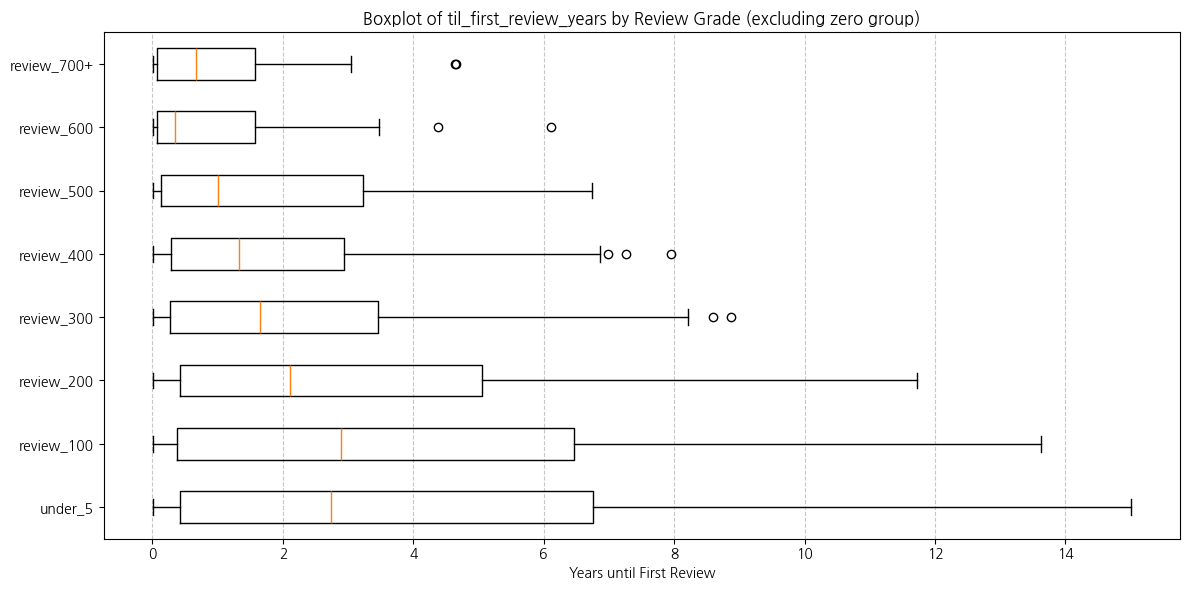

In [32]:
# zero Í∑∏Î£π Ï†úÏô∏
filtered = df_clean[df_clean["host_review_grade"] != "zero"]

plt.figure(figsize=(12,6))

# Í∑∏Î£π ÏàúÏÑú Ï†ïÎ†¨
groups_sorted = sorted(filtered["host_review_grade"].unique().tolist(),
                       key=lambda x: list(df_clean["host_review_grade"].cat.categories).index(x))

# Í∑∏Î£πÎ≥Ñ Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
data = [filtered.loc[filtered["host_review_grade"] == g, "til_first_review_years"].dropna() for g in groups_sorted]

# Î∞ïÏä§ÌîåÎ°Ø (Ïó∞ Îã®ÏúÑ Í∑∏ÎåÄÎ°ú)
plt.boxplot(data, labels=groups_sorted, vert=False)
plt.xlabel("Years until First Review")
plt.title("Boxplot of til_first_review_years by Review Grade (excluding zero group)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

-------

In [ ]:
summary = (
    df_clean
    .groupby("host_review_grade")["number_of_reviews"]
    .agg(count="size", mean="mean", median="median")
    .reset_index()
)

summary

host_review_grade  count        mean  median
0        review_100   5881   32.015474    24.0
1        review_200   1176  143.520408   141.0
2        review_300    537  242.759777   240.0
3        review_400    270  342.929630   339.5
4        review_500    112  441.321429   440.0
5        review_600     56  550.732143   557.0
6       review_700+     31  706.354839   662.0
7           under_5   1886    2.177625     2.0
8              zero   1497    0.000000     0.0

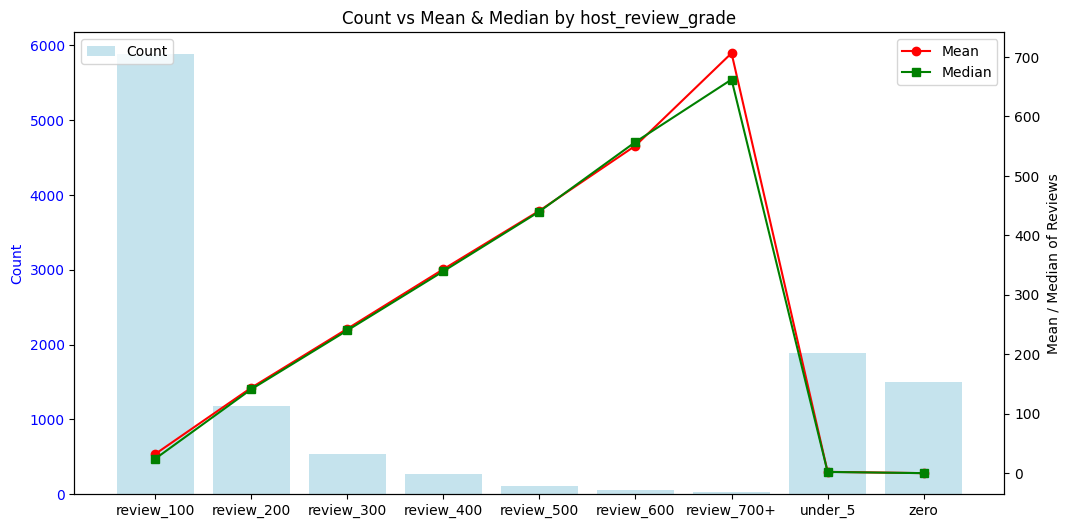

In [ ]:
import matplotlib.pyplot as plt

# ÏßëÍ≥Ñ ÌÖåÏù¥Î∏î
summary = (
    df_clean
    .groupby("host_review_grade")["number_of_reviews"]
    .agg(count="size", mean="mean", median="median")
    .reset_index()
)

# ÏãúÍ∞ÅÌôî
fig, ax1 = plt.subplots(figsize=(12,6))

# 1. count ‚Üí bar chart (ÏôºÏ™Ω yÏ∂ï)
ax1.bar(summary["host_review_grade"], summary["count"], color="lightblue", alpha=0.7, label="Count")
ax1.set_ylabel("Count", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# 2. mean/median ‚Üí line chart (Ïò§Î•∏Ï™Ω yÏ∂ï)
ax2 = ax1.twinx()
ax2.plot(summary["host_review_grade"], summary["mean"], marker="o", color="red", label="Mean")
ax2.plot(summary["host_review_grade"], summary["median"], marker="s", color="green", label="Median")
ax2.set_ylabel("Mean / Median of Reviews", color="black")
ax2.tick_params(axis="y", labelcolor="black")

# ÌÉÄÏù¥ÌãÄ & Î≤îÎ°Ä
plt.title("Count vs Mean & Median by host_review_grade")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()


In [ ]:
# host_review_grade Ïπ¥ÌÖåÍ≥†Î¶¨ ÏàúÏÑú ÏßÄÏ†ï
grade_order = ["zero","under_5","review_100","review_200","review_300",
               "review_400","review_500","review_600","review_700+"]
df_clean["host_review_grade"] = pd.Categorical(
    df_clean["host_review_grade"], categories=grade_order, ordered=True
)

# ÏùåÏàò Í∞íÏùÄ NaN Ï≤òÎ¶¨
df_clean.loc[df_clean["til_first_review_years"] < 0, "til_first_review_years"] = np.nan

# ÏöîÏïΩ Ìï®Ïàò
def grade_summary(df, value_col):
    grp = df.groupby("host_review_grade")[value_col]
    out = grp.agg(
        total_rows = "size",
        valid_rows = "count",
        mean = "mean",
        median = "median",
        std = "std",
        min = "min",
        q1 = lambda s: s.quantile(0.25),
        q3 = lambda s: s.quantile(0.75),
        max = "max"
    ).reset_index()
    out["missing_rows"] = out["total_rows"] - out["valid_rows"]
    out["missing_rate"] = (out["missing_rows"] / out["total_rows"]).round(3)
    return out

# til_first_review_yearsÏóê ÎåÄÌïú ÏöîÏïΩ
til_first_years_summary = grade_summary(df_clean, "til_first_review_years")
til_first_years_summary

/tmp/ipython-input-632305291.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby("host_review_grade")[value_col]


host_review_grade  total_rows  valid_rows      mean    median       std  \
0              zero        1497           0       NaN       NaN       NaN   
1           under_5        1886        1885  3.783313  2.746064  3.645679   
2        review_100        5881        5872  3.723144  2.891170  3.453413   
3        review_200        1176        1166  2.940980  2.197125  2.786212   
4        review_300         537         529  2.159020  1.691992  2.053270   
5        review_400         270         268  1.932483  1.352498  1.898714   
6        review_500         112         110  1.822139  1.044490  1.876401   
7        review_600          56          55  1.109377  0.350445  1.374976   
8       review_700+          31          31  1.010797  0.662560  1.250695   

        min        q1        q3        max  missing_rows  missing_rate  
0       NaN       NaN       NaN        NaN          1497         1.000  
1  0.005476  0.421629  6.762491  15.006160             1         0.001  
2  0.005476  0.377823  6.479124  13.631759             9         0.002  
3  0.005476  0.401095  5.084873  11.720739            10         0.009  
4  0.005476  0.268309  3.559206   8.865161             8         0.015  
5  0.013689  0.268309  2.938398   7.947981             2         0.007  
6  0.010951  0.122519  3.258042   6.737851             2         0.018  
7  0.013689  0.073922  1.709788   6.110883             1         0.018  
8  0.016427  0.071184  1.577002   4.648871             0         0.000

In [ ]:
#Ìò∏Ïä§ÌåÖ ÏãúÏûë Ïù¥ÌõÑ Ï≤´ Î¶¨Î∑∞ Î∞õÍ∏∞ÍπåÏßÄÏùò Í∏∞Í∞Ñ(years Í∏∞Ï§Ä)
filtered = df_clean[df_clean["host_review_grade"] != "zero"]["til_first_review_years"].dropna()

mean_val = filtered.mean()
median_val = filtered.median()

print("ÌèâÍ∑† (years):", mean_val)
print("Ï§ëÏïôÍ∞í (years):", median_val)

ÌèâÍ∑† (years): 3.4667047138468265
Ï§ëÏïôÍ∞í (years): 2.4435318275154003


/tmp/ipython-input-1765832933.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipython-input-1765832933.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(
/tmp/ipython-input-1765832933.py:21: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


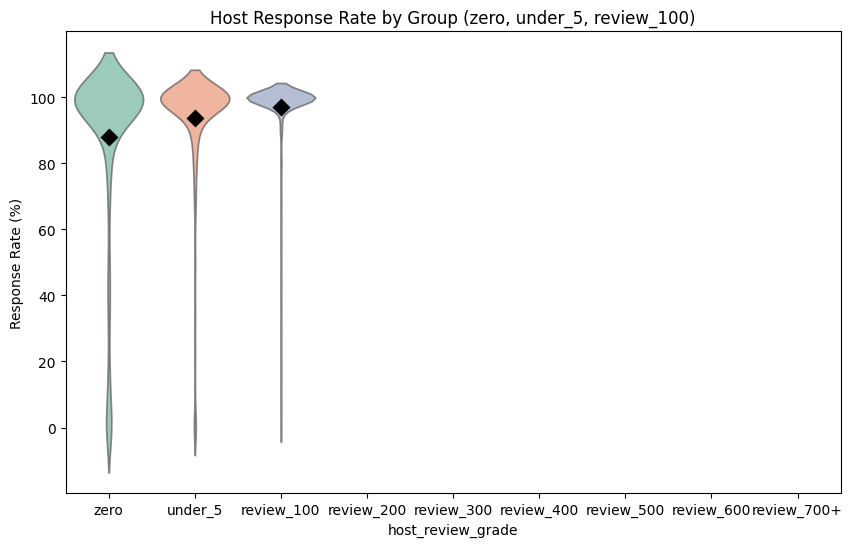

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

# ÏÑ∏ Í∑∏Î£πÎßå ÌïÑÌÑ∞ÎßÅ
subset3 = df_clean[df_clean["host_review_grade"].isin(["zero", "under_5", "review_100"])]

plt.figure(figsize=(10,6))

# 1) Î∂ÑÌè¨: Î∞îÏù¥Ïò¨Î¶∞ ÌîåÎ°Ø
sns.violinplot(
    x="host_review_grade",
    y="host_response_rate",
    data=subset3,
    inner=None, palette="Set2", alpha=0.7
)

# 2) ÌèâÍ∑†Í∞í ÌëúÏãú: pointplot
sns.pointplot(
    x="host_review_grade",
    y="host_response_rate",
    data=subset3,
    ci=95, color="black", join=False, markers="D"
)

plt.title("Host Response Rate by Group (zero, under_5, review_100)")
plt.ylabel("Response Rate (%)")
plt.xlabel("host_review_grade")
plt.show()

#ÏãúÍ∞ÅÌôî

###Î¶¨Î∑∞ ÏàòÍ∞Ä 0Ïù¥ ÏïÑÎãå ÏàôÏÜå Ï§ë Î¶¨Î∑∞ Í∞úÏàò((number_of_reviews)) vs

ÏùëÎãµÎ•†(host_response_rate) / ÏùëÎãµÏÜçÎèÑ(host_response_time) / ÏàòÎùΩÎ•†(host_acceptance_rate)

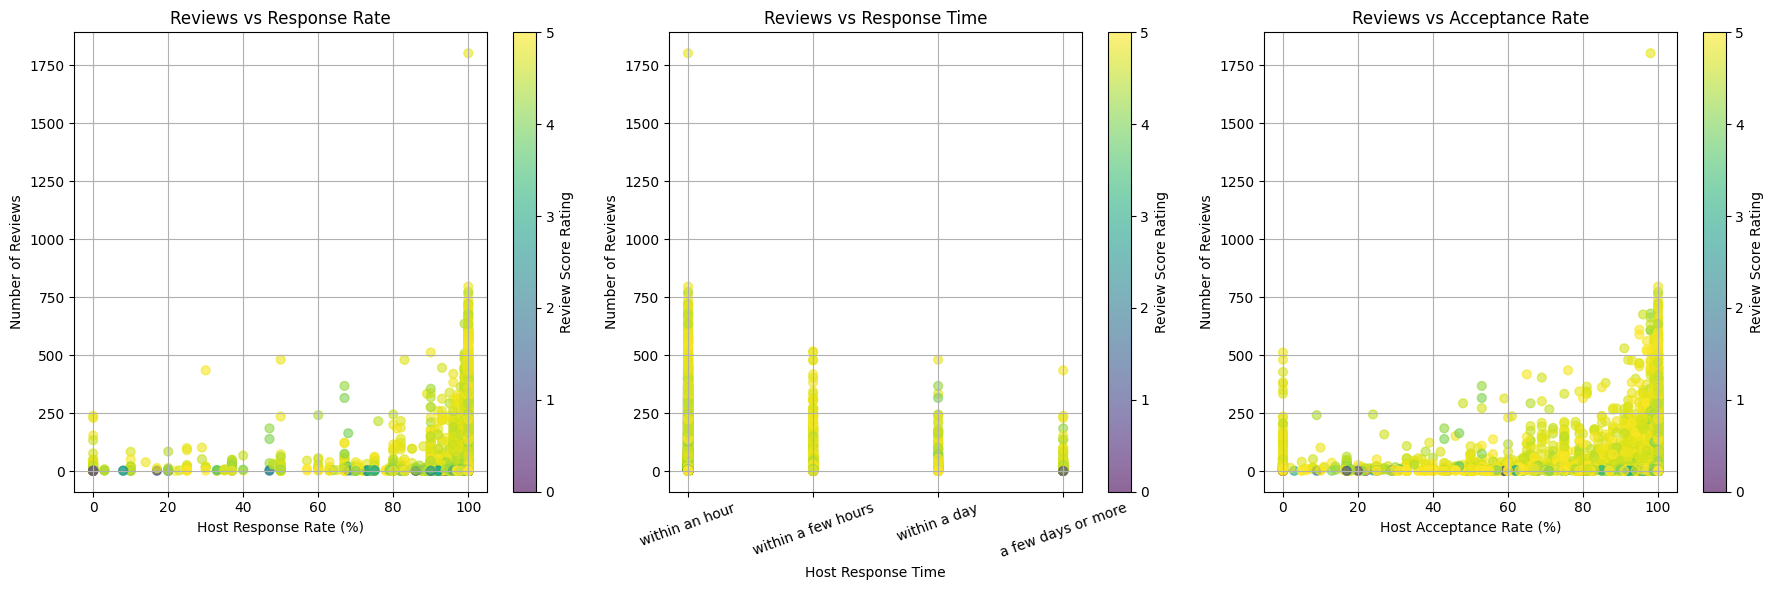

In [ ]:
import matplotlib.pyplot as plt

# ÏùëÎãµÏÜçÎèÑ ‚Üí Ïà´Ïûê Îß§Ìïë
response_order = {
    'within an hour': 1,
    'within a few hours': 2,
    'within a day': 3,
    'a few days or more': 4
}
response_time_num = df_clean.loc[df_clean['has_review'], 'host_response_time'].map(response_order)

# Î¶¨Î∑∞ ÏûàÎäî Îç∞Ïù¥ÌÑ∞ ÌïÑÌÑ∞
mask = df_clean['has_review']

plt.figure(figsize=(18,6))

# (a) ÏùëÎãµÎ•† vs Î¶¨Î∑∞Ïàò
plt.subplot(1,3,1)
sc0 = plt.scatter(
    df_clean.loc[mask, 'host_response_rate'],
    df_clean.loc[mask, 'number_of_reviews'],
    c=df_clean.loc[mask, 'review_scores_rating'],
    cmap='viridis',
    alpha=0.6,
    s=40
)
plt.colorbar(sc0, label='Review Score Rating')
plt.xlabel('Host Response Rate (%)')
plt.ylabel('Number of Reviews')
plt.title('Reviews vs Response Rate')
plt.grid(True)

# (b) ÏùëÎãµÏÜçÎèÑ vs Î¶¨Î∑∞Ïàò
plt.subplot(1,3,2)
sc1 = plt.scatter(
    response_time_num,
    df_clean.loc[mask, 'number_of_reviews'],
    c=df_clean.loc[mask, 'review_scores_rating'],
    cmap='viridis',
    alpha=0.6,
    s=40
)
plt.colorbar(sc1, label='Review Score Rating')
plt.xticks(list(response_order.values()), list(response_order.keys()), rotation=20)
plt.xlabel('Host Response Time')
plt.ylabel('Number of Reviews')
plt.title('Reviews vs Response Time')
plt.grid(True)

# (c) ÏàòÎùΩÎ•† vs Î¶¨Î∑∞Ïàò
plt.subplot(1,3,3)
sc2 = plt.scatter(
    df_clean.loc[mask, 'host_acceptance_rate'],
    df_clean.loc[mask, 'number_of_reviews'],
    c=df_clean.loc[mask, 'review_scores_rating'],
    cmap='viridis',
    alpha=0.6,
    s=40
)
plt.colorbar(sc2, label='Review Score Rating')
plt.xlabel('Host Acceptance Rate (%)')
plt.ylabel('Number of Reviews')
plt.title('Reviews vs Acceptance Rate')
plt.grid(True)

plt.tight_layout()
plt.show()

###

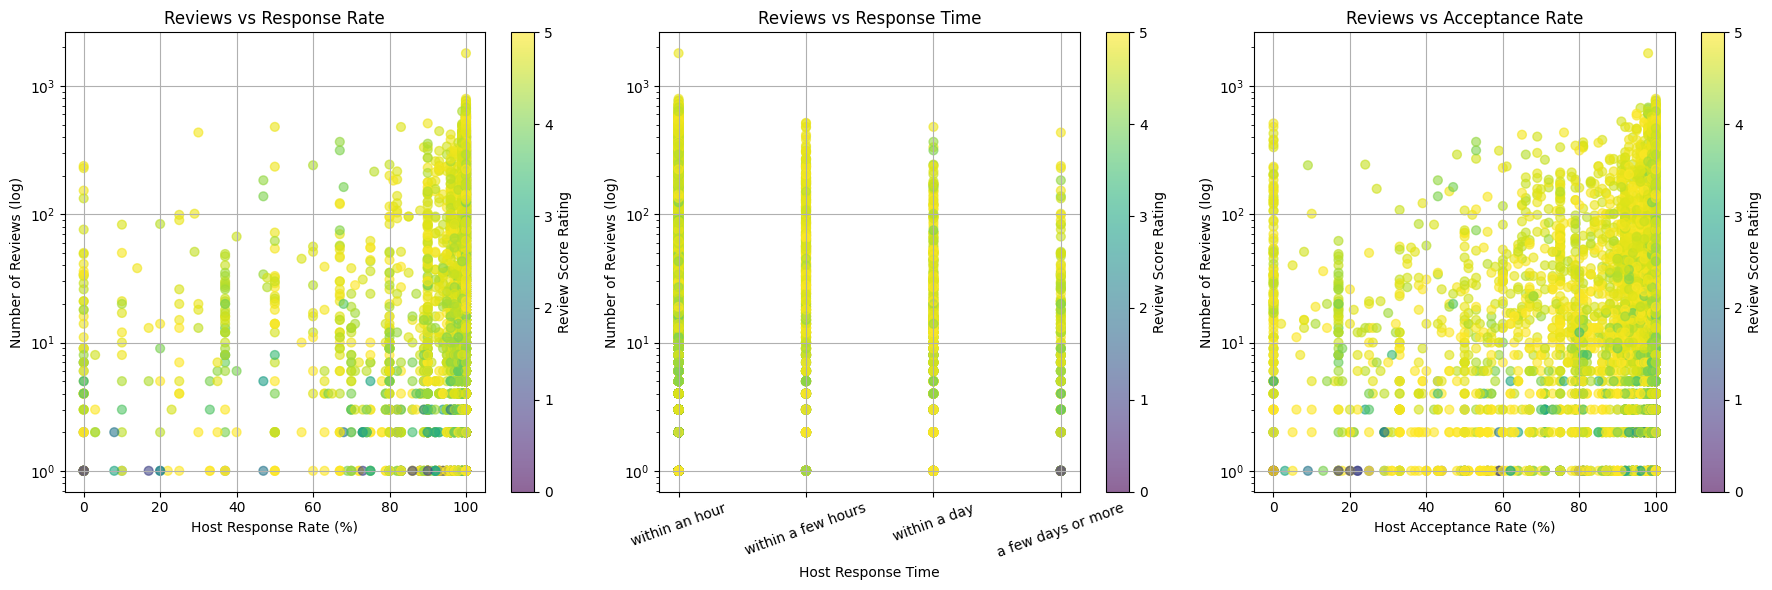

In [ ]:
import matplotlib.pyplot as plt

# ÏùëÎãµÏÜçÎèÑ ‚Üí Ïà´Ïûê Îß§Ìïë
response_order = {
    'within an hour': 1,
    'within a few hours': 2,
    'within a day': 3,
    'a few days or more': 4
}
response_time_num = df_clean.loc[df_clean['has_review'], 'host_response_time'].map(response_order)

# Î¶¨Î∑∞ ÏûàÎäî Îç∞Ïù¥ÌÑ∞ ÌïÑÌÑ∞
mask = df_clean['has_review']

fig, axes = plt.subplots(1, 3, figsize=(18,6))

# (a) ÏùëÎãµÎ•† vs Î¶¨Î∑∞Ïàò
sc0 = axes[0].scatter(
    df_clean.loc[mask, 'host_response_rate'],
    df_clean.loc[mask, 'number_of_reviews'],
    c=df_clean.loc[mask, 'review_scores_rating'],
    cmap='viridis',
    alpha=0.6,
    s=40
)
axes[0].set_yscale('log')
axes[0].set_xlabel('Host Response Rate (%)')
axes[0].set_ylabel('Number of Reviews (log)')
axes[0].set_title('Reviews vs Response Rate')
axes[0].grid(True)
fig.colorbar(sc0, ax=axes[0], label='Review Score Rating')

# (b) ÏùëÎãµÏÜçÎèÑ vs Î¶¨Î∑∞Ïàò
sc1 = axes[1].scatter(
    response_time_num,
    df_clean.loc[mask, 'number_of_reviews'],
    c=df_clean.loc[mask, 'review_scores_rating'],
    cmap='viridis',
    alpha=0.6,
    s=40
)
axes[1].set_yscale('log')
axes[1].set_xticks(list(response_order.values()))
axes[1].set_xticklabels(list(response_order.keys()), rotation=20)
axes[1].set_xlabel('Host Response Time')
axes[1].set_ylabel('Number of Reviews (log)')
axes[1].set_title('Reviews vs Response Time')
axes[1].grid(True)
fig.colorbar(sc1, ax=axes[1], label='Review Score Rating')

# (c) ÏàòÎùΩÎ•† vs Î¶¨Î∑∞Ïàò
sc2 = axes[2].scatter(
    df_clean.loc[mask, 'host_acceptance_rate'],
    df_clean.loc[mask, 'number_of_reviews'],
    c=df_clean.loc[mask, 'review_scores_rating'],
    cmap='viridis',
    alpha=0.6,
    s=40
)
axes[2].set_yscale('log')
axes[2].set_xlabel('Host Acceptance Rate (%)')
axes[2].set_ylabel('Number of Reviews (log)')
axes[2].set_title('Reviews vs Acceptance Rate')
axes[2].grid(True)
fig.colorbar(sc2, ax=axes[2], label='Review Score Rating')

plt.tight_layout()
plt.show()


#ÏïÑÎûòÎäî Î¨¥Ïãú

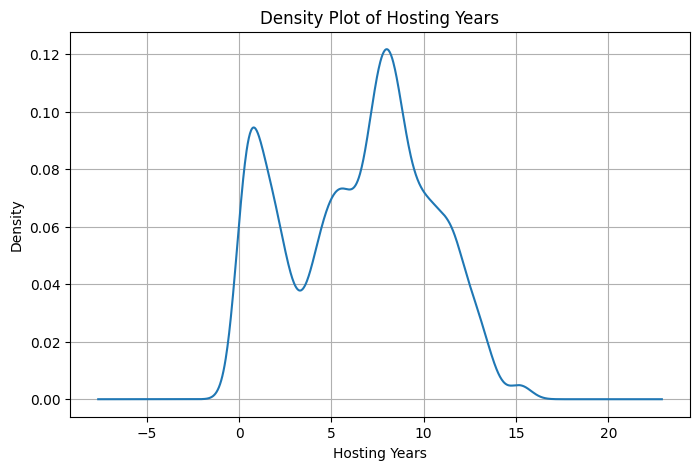

In [ ]:
import matplotlib.pyplot as plt
df['hosting_years'].dropna().plot(kind='kde', figsize=(8,5))
plt.title('Density Plot of Hosting Years')
plt.xlabel('Hosting Years')
plt.grid(True)
plt.show()

In [ ]:
df['first_review'] = pd.to_datetime(df['first_review'])
df['last_review'] = pd.to_datetime(df['last_review'])
df['til_first_review_days'] = (df['first_review']-df['host_since']).dt.days
df['til_first_review_years'] = df['til_first_review_days'] / 365.25

df['til_first_review_days'].describe()

count    9949.000000
mean     1260.362448
std      1224.851076
min     -1941.000000
25%       131.000000
50%       884.000000
75%      2231.000000
max      5481.000000
Name: til_first_review_days, dtype: float64

In [ ]:
df['has_availability'].isnull().sum()

np.int64(524)

In [ ]:
df['id'].duplicated().sum()

np.int64(0)

In [ ]:
df['id'].isnull().sum()

np.int64(0)

In [ ]:
df['has_review'] = df['number_of_reviews'] > 0
print(df['has_review'].value_counts())

has_review
True     9949
False    1497
Name: count, dtype: int64


In [ ]:
#ÌèâÍ∑† ÌèâÏ†êÏù¥ 4.9 Ïù¥ÏÉÅÏù∏ ÏàôÏÜå vs ÎØ∏ÎßåÏù∏ ÏàôÏÜå ÎπÑÏú®

# null Í∞í Ï†úÏô∏
ratings = df['review_scores_rating'].dropna()

# Ï°∞Í±¥ ÎÇòÎàÑÍ∏∞
above_49 = (ratings >= 4.9).sum()
below_49 = (ratings < 4.9).sum()

# ÎπÑÏú® Í≥ÑÏÇ∞
total = len(ratings)
above_ratio = above_49 / total * 100
below_ratio = below_49 / total * 100

print(f"4.9 Ïù¥ÏÉÅ ÏàôÏÜå ÎπÑÏú®: {above_ratio:.2f}%")
print(f"4.9 ÎØ∏Îßå ÏàôÏÜå ÎπÑÏú®: {below_ratio:.2f}%")

4.9 Ïù¥ÏÉÅ ÏàôÏÜå ÎπÑÏú®: 32.20%
4.9 ÎØ∏Îßå ÏàôÏÜå ÎπÑÏú®: 67.80%


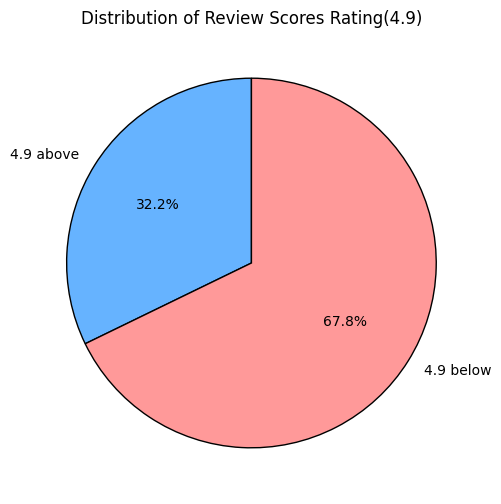

In [ ]:
import matplotlib.pyplot as plt


#ÌååÏù¥Ï∞®Ìä∏
labels = ['4.9 above', '4.9 below']
sizes = [above_49, below_49]
colors = ['#66b3ff', '#ff9999']

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%.1f%%', startangle=90, colors=colors, wedgeprops={'edgecolor':'black'})
plt.title('Distribution of Review Scores Rating(4.9)')
plt.show()

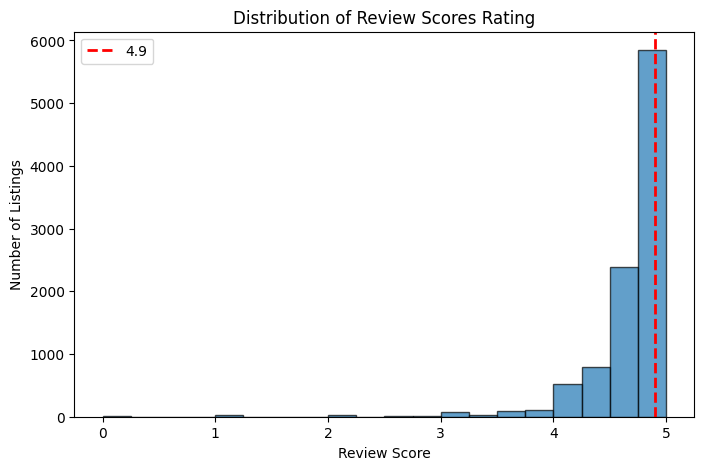

In [ ]:
import matplotlib.pyplot as plt

# ÌûàÏä§ÌÜ†Í∑∏Îû®
plt.figure(figsize=(8,5))
plt.hist(ratings, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(4.9, color='red', linestyle='--', linewidth=2, label='4.9')
plt.title('Distribution of Review Scores Rating')
plt.xlabel('Review Score')
plt.ylabel('Number of Listings')
plt.legend()
plt.show()

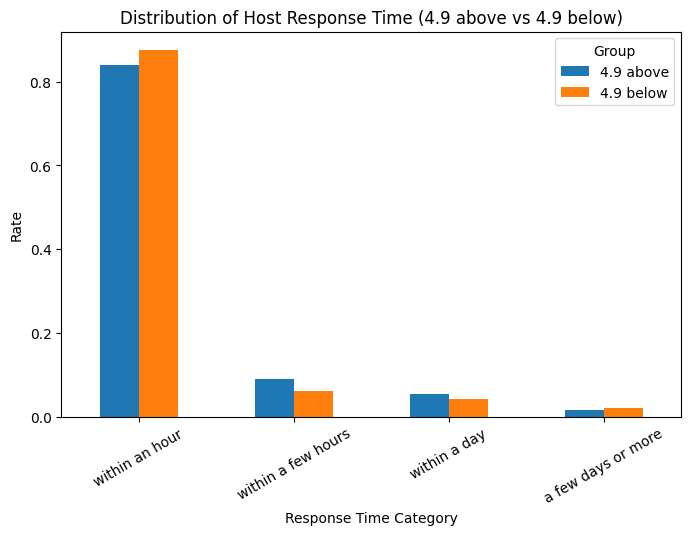

In [ ]:
#host_response_time Î∂ÑÌè¨

# ÌèâÏ†ê Í∏∞Ï§ÄÏúºÎ°ú Í∑∏Î£π ÎÇòÎàÑÍ∏∞ (NaNÏùÄ False Ï≤òÎ¶¨Îê®)
above_mask = df['review_scores_rating'] >= 4.9
below_mask = df['review_scores_rating'] < 4.9

# Í∑∏Î£πÎ≥Ñ host_response_time Î∂ÑÌè¨ Í≥ÑÏÇ∞
above_response = df.loc[above_mask, 'host_response_time'].value_counts(normalize=True)
below_response = df.loc[below_mask, 'host_response_time'].value_counts(normalize=True)

# Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏúºÎ°ú Ìï©ÏπòÍ∏∞
response_df = pd.DataFrame({
    '4.9 above': above_response,
    '4.9 below': below_response
}).fillna(0)

# ÎßâÎåÄÍ∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
response_df.plot(kind='bar', figsize=(8,5))
plt.title('Distribution of Host Response Time (4.9 above vs 4.9 below)')
plt.ylabel('Rate')
plt.xlabel('Response Time Category')
plt.xticks(rotation=30)
plt.legend(title='Group')
plt.show()

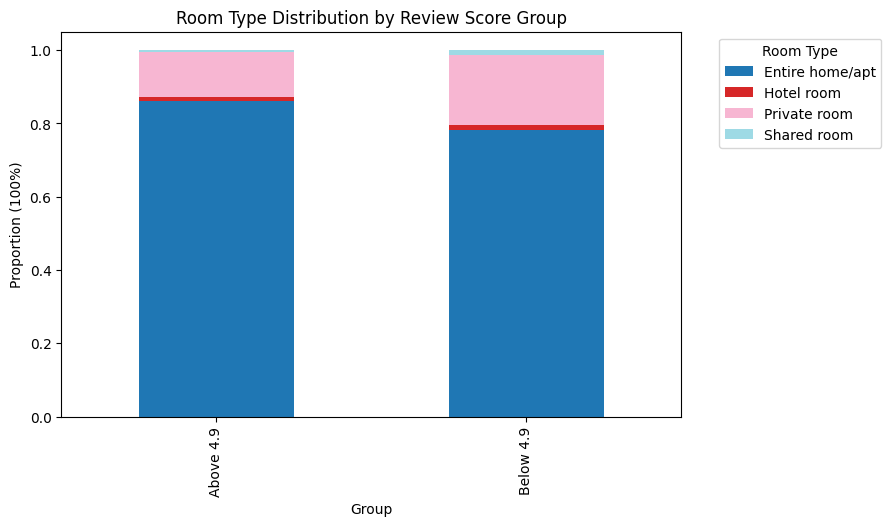

In [ ]:
#Í∞Å Í∑∏Î£πÎ≥ÑÎ°ú Î∞© ÌÉÄÏûÖÏù¥ Ïñ¥ÎñªÍ≤åÎêòÎäîÏßÄ 100% Ïä§ÌÉù ÎßâÎåÄ
# Room type distribution (ratio) for each group
above_room = df.loc[above_mask, 'room_type'].value_counts(normalize=True)
below_room = df.loc[below_mask, 'room_type'].value_counts(normalize=True)

# Combine into one DataFrame
room_df = pd.DataFrame({
    'Above 4.9': above_room,
    'Below 4.9': below_room
}).fillna(0).T   # transpose: groups as rows, room_type as columns

# 100% stacked bar chart
room_df.plot(kind='bar', stacked=True, figsize=(8,5), colormap='tab20')
plt.title('Room Type Distribution by Review Score Group')
plt.ylabel('Proportion (100%)')
plt.xlabel('Group')
plt.legend(title='Room Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
#ÌèâÏ†êÏù¥ Ï°¥Ïû¨ÌïòÎ©¥ÏÑú Î¶¨Î∑∞ Í∞úÏàò 5Í∞ú Í∏∞Ï§ÄÏúºÎ°ú ÎπÑÏú® Í≥ÑÏÇ∞

# ratingsÏóêÏÑú Í∞ÄÏ†∏Ïò® Ïù∏Îç±Ïä§Î°ú ÌïÑÌÑ∞ÎßÅ
valid_idx = ratings.index
reviews_filtered = df.loc[valid_idx, 'number_of_reviews'].dropna()

# Ï°∞Í±¥Î≥Ñ Í∞úÏàò
less_than_5 = (reviews_filtered < 5).sum()
five_or_more = (reviews_filtered >= 5).sum()

# Ï†ÑÏ≤¥
total = len(reviews_filtered)

# ÎπÑÏú®
less_ratio = less_than_5 / total * 100
five_ratio = five_or_more / total * 100

print(f"Reviews < 5: {less_ratio:.2f}%")
print(f"Reviews >= 5: {five_ratio:.2f}%")

Reviews < 5: 18.97%
Reviews >= 5: 81.03%


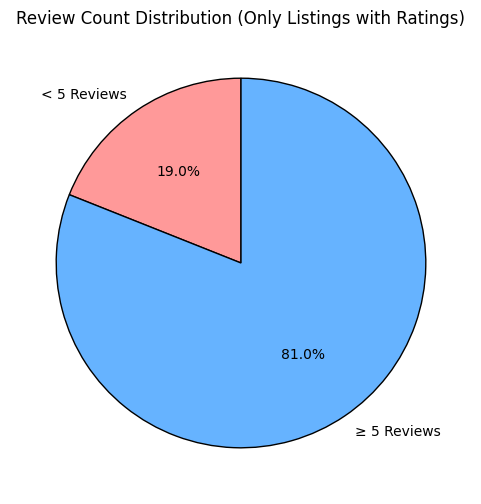

In [ ]:
labels = ['< 5 Reviews', '‚â• 5 Reviews']
sizes = [less_than_5, five_or_more]
colors = ['#ff9999', '#66b3ff']

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%.1f%%', startangle=90,
        colors=colors, wedgeprops={'edgecolor':'black'})
plt.title('Review Count Distribution (Only Listings with Ratings)')
plt.show()

In [ ]:
#ÌèâÏ†êÏù¥ ÏûàÏßÄÎßå Í∑∏ Ï§ëÏóêÏÑú ÌèâÏ†êÏù¥ 5Í∞ú ÎØ∏Îßå/Ïù¥ÏÉÅÏù∏ Í∑∏Î£πÏùò ÌèâÏ†ê ÌèâÍ∑†

# Í∑∏Î£π ÎÇòÎàÑÍ∏∞
less_mask = reviews_filtered < 5
more_mask = reviews_filtered >= 5

# Í∑∏Î£πÎ≥Ñ ÌèâÏ†ê ÌèâÍ∑†
less_mean = ratings.loc[less_mask].mean()
more_mean = ratings.loc[more_mask].mean()

print(f"Average rating (< 5 reviews): {less_mean:.2f}")
print(f"Average rating (‚â• 5 reviews): {more_mean:.2f}")

Average rating (< 5 reviews): 4.51
Average rating (‚â• 5 reviews): 4.72


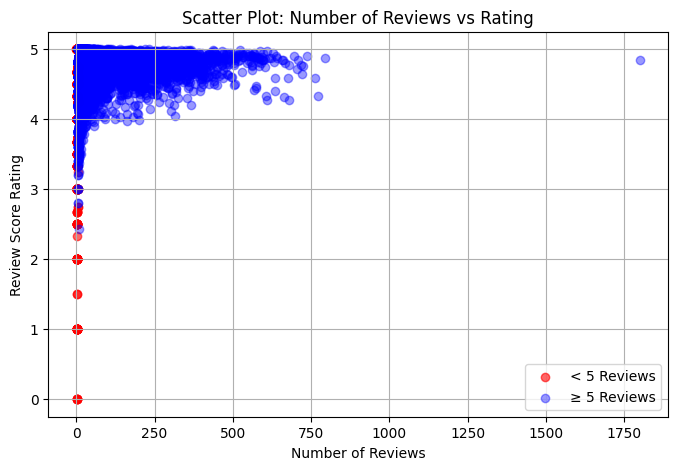

In [ ]:
#Î¶¨Î∑∞ 5Í∞úÎØ∏Îßå, Ïù¥ÏÉÅ Í∑∏Î£πÎ≥Ñ ÌèâÏ†ê ÏÇ∞Ìè¨ÎèÑ

plt.figure(figsize=(8,5))

# < 5 reviews
plt.scatter(reviews_filtered[less_mask], ratings[less_mask],
            alpha=0.6, color='red', label='< 5 Reviews')

# ‚â• 5 reviews
plt.scatter(reviews_filtered[more_mask], ratings[more_mask],
            alpha=0.4, color='blue', label='‚â• 5 Reviews')

plt.title('Scatter Plot: Number of Reviews vs Rating')
plt.xlabel('Number of Reviews')
plt.ylabel('Review Score Rating')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
less_count = less_mask.sum()
more_count = more_mask.sum()

print(f"Number of listings with < 5 reviews: {less_count}")
print(f"Number of listings with ‚â• 5 reviews: {more_count}")

Number of listings with < 5 reviews: 1888
Number of listings with ‚â• 5 reviews: 8063


In [ ]:
df['number_of_reviews'].describe()

count    11446.000000
mean        59.958850
std         99.617144
min          0.000000
25%          3.000000
50%         18.000000
75%         70.000000
max       1801.000000
Name: number_of_reviews, dtype: float64

In [ ]:
zero_reviews = (df['number_of_reviews'] == 0).sum()
zero_reviews

np.int64(1497)

In [ ]:
ratings.sum()

np.float64(46590.97)

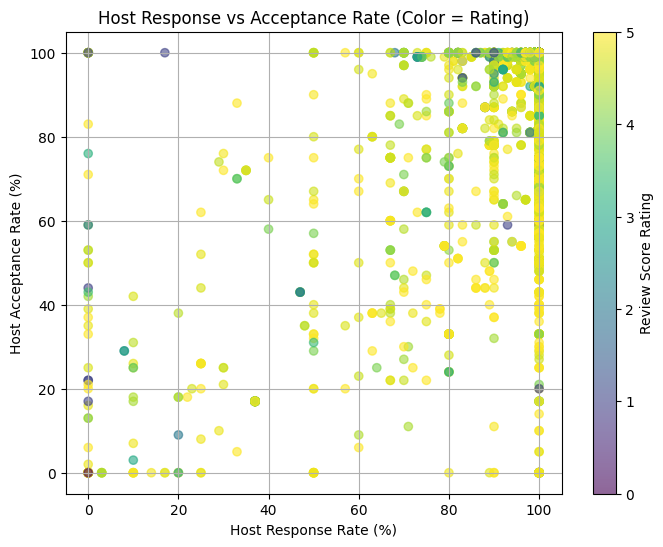

In [ ]:
import matplotlib.pyplot as plt

# Ï°∞Í±¥ ÌïÑÌÑ∞ÎßÅ
mask = (df['number_of_reviews'] > 0) & (df['review_scores_rating'].notna())
df_valid = df.loc[mask].copy()

# Î¨∏Ïûê(%) ‚Üí Ïà´Ïûê Î≥ÄÌôò
df_valid['host_response_rate'] = df_valid['host_response_rate'].replace('%','', regex=True).astype(float)
df_valid['host_acceptance_rate'] = df_valid['host_acceptance_rate'].replace('%','', regex=True).astype(float)

# ÏÇ∞Ï†êÎèÑ with ÏÉâ = ÌèâÏ†ê
plt.figure(figsize=(8,6))
sc = plt.scatter(
    df_valid['host_response_rate'],
    df_valid['host_acceptance_rate'],
    c=df_valid['review_scores_rating'],
    cmap='viridis',
    alpha=0.6
)

plt.colorbar(sc, label='Review Score Rating')
plt.title('Host Response vs Acceptance Rate (Color = Rating)')
plt.xlabel('Host Response Rate (%)')
plt.ylabel('Host Acceptance Rate (%)')
plt.grid(True)
plt.show()


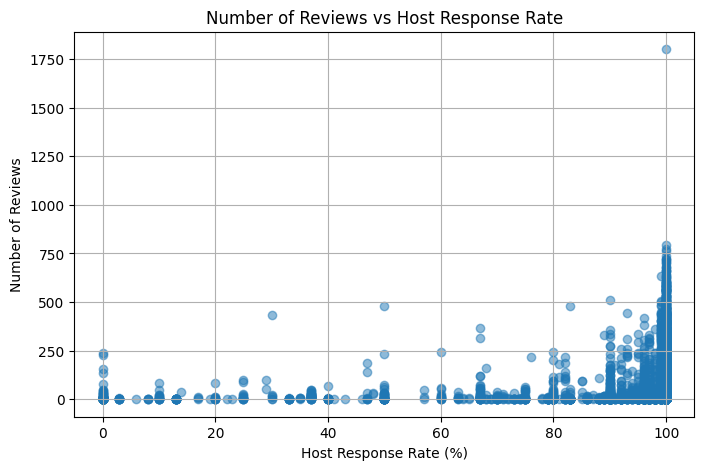

In [ ]:
#y: Î¶¨Î∑∞ Í∞úÏàò x: Ìò∏Ïä§Ìä∏ ÏùëÎãµÎ•†

# ÏùëÎãµÎ•†(%) ‚Üí Ïà´ÏûêÌòï Î≥ÄÌôò
df['host_response_rate'] = df['host_response_rate'].replace('%','', regex=True).astype(float)

plt.figure(figsize=(8,5))
plt.scatter(df['host_response_rate'], df['number_of_reviews'], alpha=0.5)
plt.title('Number of Reviews vs Host Response Rate')
plt.xlabel('Host Response Rate (%)')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()

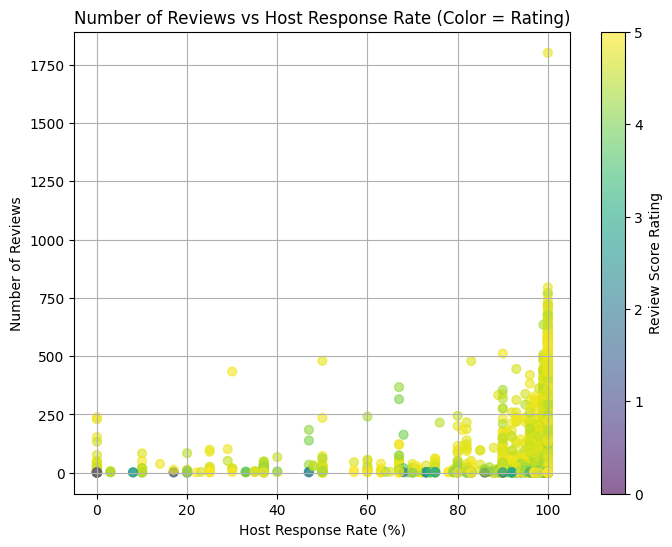

In [ ]:
#y: Î¶¨Î∑∞ Í∞úÏàò x: Ìò∏Ïä§Ìä∏ ÏùëÎãµÎ•†, Î≥ÑÏ†êÏóê Îî∞Îùº ÏÉâÏÉÅ Íµ¨Î∂Ñ (Î≤ÑÎ∏îÏ∞®Ìä∏)
# ÏùëÎãµÎ•†(%) ‚Üí Ïà´ÏûêÌòï Î≥ÄÌôò
df['host_response_rate'] = df['host_response_rate'].replace('%','', regex=True).astype(float)

plt.figure(figsize=(8,6))
sc = plt.scatter(
    df['host_response_rate'],
    df['number_of_reviews'],
    c=df['review_scores_rating'],   # ÏÉâÏÉÅ: ÌèâÏ†ê
    cmap='viridis',                 # ÏÉâÏÉÅ ÌåîÎ†àÌä∏
    alpha=0.6,
    s=40                            # Ï†ê ÌÅ¨Í∏∞ (bubble size)
)

plt.colorbar(sc, label='Review Score Rating')
plt.title('Number of Reviews vs Host Response Rate (Color = Rating)')
plt.xlabel('Host Response Rate (%)')
plt.ylabel('Number of Reviews')
plt.grid(True)

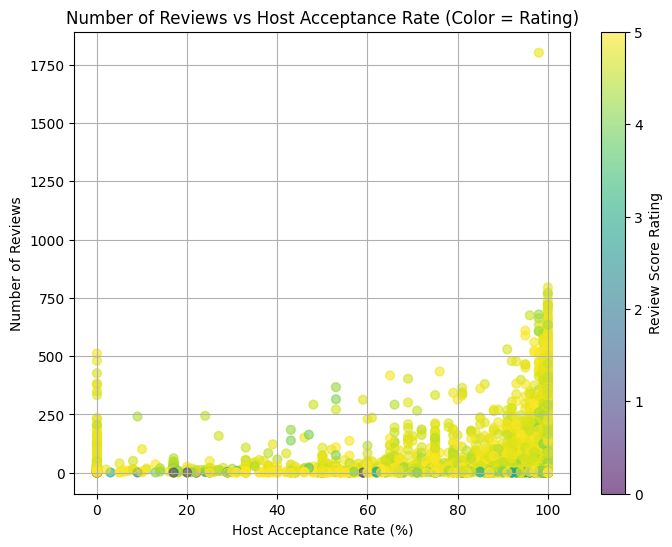

In [ ]:
#y: Î¶¨Î∑∞ Í∞úÏàò x: Ìò∏Ïä§Ìä∏ ÏàòÎùΩÎ•†, Î≥ÑÏ†êÏóê Îî∞Îùº ÏÉâÏÉÅ Íµ¨Î∂Ñ (Î≤ÑÎ∏îÏ∞®Ìä∏)

# ÏàòÎùΩÎ•†(%) ‚Üí Ïà´ÏûêÌòï Î≥ÄÌôò
df['host_acceptance_rate'] = df['host_acceptance_rate'].replace('%','', regex=True).astype(float)

plt.figure(figsize=(8,6))
sc = plt.scatter(
    df['host_acceptance_rate'],
    df['number_of_reviews'],
    c=df['review_scores_rating'],   # ÏÉâÏÉÅ: ÌèâÏ†ê
    cmap='viridis',
    alpha=0.6,
    s=40
)

plt.colorbar(sc, label='Review Score Rating')
plt.title('Number of Reviews vs Host Acceptance Rate (Color = Rating)')
plt.xlabel('Host Acceptance Rate (%)')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()

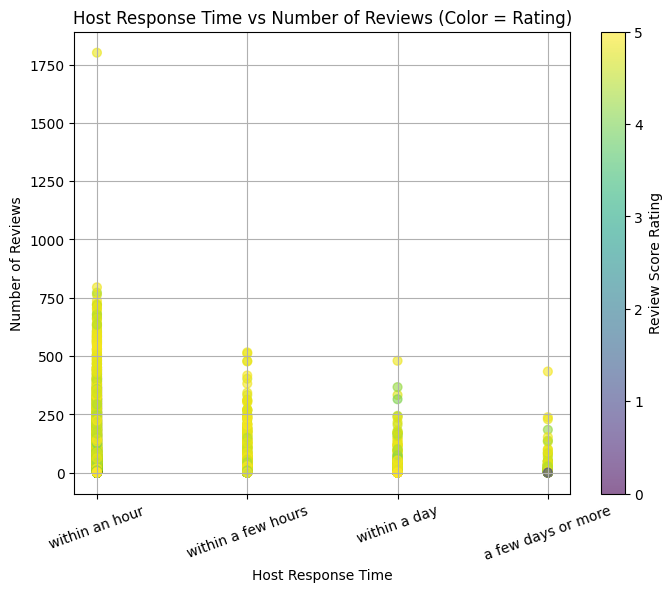

In [ ]:
#y: Î¶¨Î∑∞ Í∞úÏàò x: Ìò∏Ïä§Ìä∏ ÏùëÎãµ ÏãúÍ∞Ñ, Î≥ÑÏ†êÏóê Îî∞Îùº ÏÉâÏÉÅ Íµ¨Î∂Ñ
# ÏùëÎãµ ÏÜçÎèÑ ÏàúÏÑú Ï†ïÏùò
response_order = {
    'within an hour': 1,
    'within a few hours': 2,
    'within a day': 3,
    'a few days or more': 4
}

# Îß§ÌïëÌï¥ÏÑú Ïà´ÏûêÌòïÏúºÎ°ú Î≥ÄÌôò
df['response_time_num'] = df['host_response_time'].map(response_order)

plt.figure(figsize=(8,6))
sc = plt.scatter(
    df['response_time_num'],
    df['number_of_reviews'],
    c=df['review_scores_rating'],   # ÏÉâÏÉÅ = ÌèâÏ†ê
    cmap='viridis',
    alpha=0.6,
    s=40
)

# Ïª¨Îü¨Î∞î
plt.colorbar(sc, label='Review Score Rating')

# xÏ∂ï Î†àÏù¥Î∏îÏùÑ Îã§Ïãú Ïπ¥ÌÖåÍ≥†Î¶¨Î°ú ÍµêÏ≤¥
plt.xticks(list(response_order.values()), list(response_order.keys()), rotation=20)

plt.title('Host Response Time vs Number of Reviews (Color = Rating)')
plt.xlabel('Host Response Time')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()

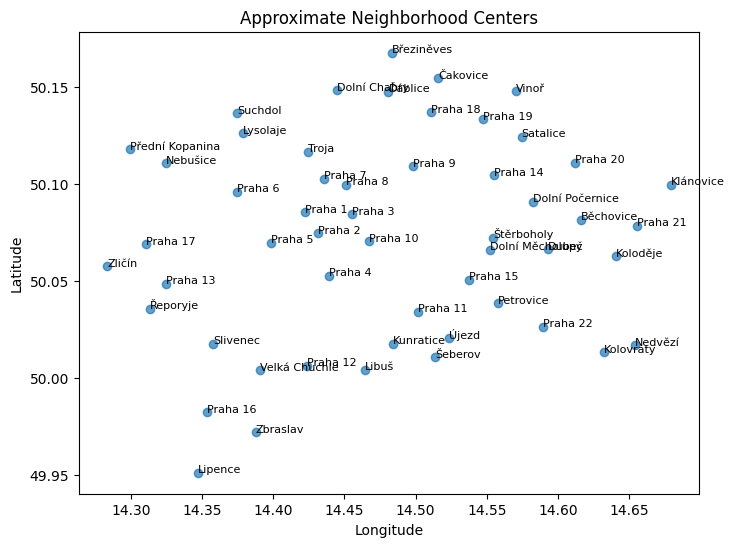

In [ ]:
# ÏßÄÏó≠ ÏãúÍ∞ÅÌôî

# Ïú†Ìö®Ìïú ÏúÑÎèÑ/Í≤ΩÎèÑÎßå
df_valid_geo = df[['neighbourhood_cleansed', 'latitude', 'longitude']].dropna()

# ÎèôÎÑ§Î≥Ñ ÌèâÍ∑† Ï¢åÌëú Í≥ÑÏÇ∞. Í∞Å neighbourhood_cleansed Î≥ÑÎ°ú ÌèâÍ∑† ÏúÑÎèÑ/Í≤ΩÎèÑÎ•º Íµ¨ÌïòÎ©¥, Í∑∏ ÏßÄÏó≠Ïùò ÎåÄÎûµÏ†ÅÏù∏ Ï§ëÏã¨ Ï¢åÌëúÍ∞Ä Îê®
geo_centers = df_valid_geo.groupby('neighbourhood_cleansed')[['latitude','longitude']].mean()

# Î≥µÏÇ¨Î≥∏ ÏÉùÏÑ±
df_cleans_geo = df.copy()

# Í≤∞Ï∏°Ïπò Ï±ÑÏö∞Í∏∞ (Î≥µÏÇ¨Î≥∏ Í∏∞Ï§ÄÏúºÎ°ú)
df_cleans_geo['latitude'] = df_cleans_geo['latitude'].fillna(df_cleans_geo['neighbourhood_cleansed'].map(geo_centers['latitude']))
df_cleans_geo['longitude'] = df_cleans_geo['longitude'].fillna(df_cleans_geo['neighbourhood_cleansed'].map(geo_centers['longitude']))

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8,6))
plt.scatter(geo_centers['longitude'], geo_centers['latitude'], alpha=0.7)
for name, (lat, lon) in geo_centers.iterrows():
    plt.text(lon, lat, name, fontsize=8)
plt.title("Approximate Neighborhood Centers")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

<>:10: SyntaxWarning: invalid escape sequence '\$'
<>:10: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-922155371.py:10: SyntaxWarning: invalid escape sequence '\$'
  tmp['price'] = pd.to_numeric(tmp['price'].replace('[\$,]', '', regex=True), errors='coerce')


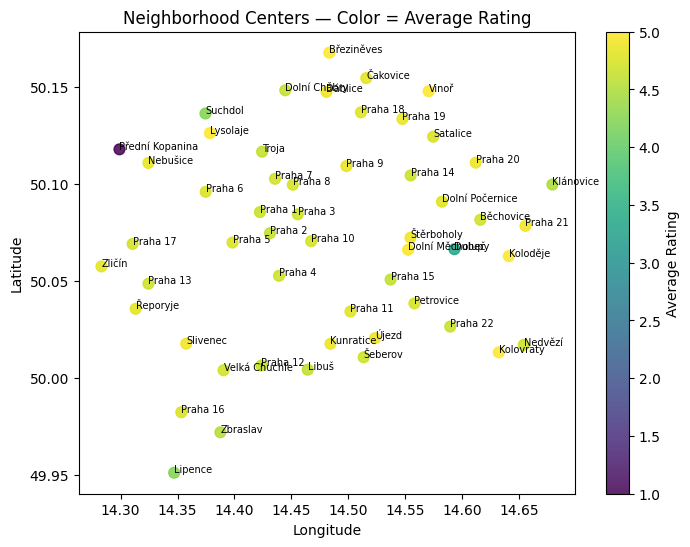

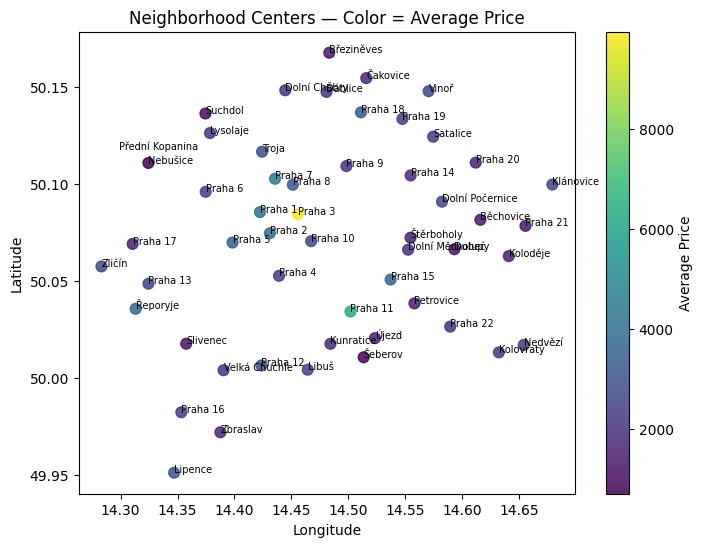

In [ ]:
#Í∞Å ÎèÑÏãúÏùò ÌèâÏ†êÏùÑ ÏÉâÏÉÅÏúºÎ°ú ÎÇòÌÉÄÎÇ¥Îäî Ï∞®Ìä∏ ÌïòÎÇò, Í∞ÄÍ≤©ÏùÑ ÏÉâÏÉÅÏúºÎ°ú ÎÇòÌÉÄÎÇ¥Îäî Ï∞®Ìä∏


# --- Prep ---
# If df_cleans_geo doesn't exist yet, fall back to df
base = df_cleans_geo if 'df_cleans_geo' in globals() else df.copy()

# Price ‚Üí numeric
tmp = base[['neighbourhood_cleansed','latitude','longitude','review_scores_rating','price']].copy()
tmp['price'] = pd.to_numeric(tmp['price'].replace('[\$,]', '', regex=True), errors='coerce')

# Drop rows without coords (centers need lat/lon)
tmp = tmp.dropna(subset=['latitude','longitude'])

# Neighborhood-level centers + metrics
agg = tmp.groupby('neighbourhood_cleansed', as_index=False).agg(
    latitude=('latitude','mean'),
    longitude=('longitude','mean'),
    avg_rating=('review_scores_rating','mean'),
    avg_price=('price','mean')
).dropna(subset=['latitude','longitude'])

# --- Chart 1: color by average rating ---
plt.figure(figsize=(8,6))
sc1 = plt.scatter(
    agg['longitude'],
    agg['latitude'],
    c=agg['avg_rating'],
    s=60,
    alpha=0.85
)
plt.colorbar(sc1, label='Average Rating')
plt.title('Neighborhood Centers ‚Äî Color = Average Rating')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# optional tiny labels (comment out if cluttered)
for _, r in agg.iterrows():
    plt.text(r['longitude'], r['latitude'], str(r['neighbourhood_cleansed']), fontsize=7)

plt.show()

# --- Chart 2: color by average price ---
plt.figure(figsize=(8,6))
sc2 = plt.scatter(
    agg['longitude'],
    agg['latitude'],
    c=agg['avg_price'],
    s=60,
    alpha=0.85
)
plt.colorbar(sc2, label='Average Price')
plt.title('Neighborhood Centers ‚Äî Color = Average Price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# optional tiny labels
for _, r in agg.iterrows():
    plt.text(r['longitude'], r['latitude'], str(r['neighbourhood_cleansed']), fontsize=7)

plt.show()

In [ ]:
df_cleans_geo.to_csv("df_cleans_geo.csv", index=False, encoding="utf-8-sig")

In [ ]:
df['last_scraped'].unique()

array(['2024-03-25', '2024-03-26', '2023-12-20', '2023-06-24',
       '2023-09-17'], dtype=object)